# Combine & seasonal NFL performance data: Do numbers matter and how strong is their influence on performance in competition?

The NFL Scouting Combine, also known as the National Invitational Camp (NIC), is a four-day, invitation-only event held annually in Indianapolis. It allows NFL teams to evaluate the top draft-eligible college football players through a series of medical, mental, and physical tests. The Combine is a key step in the player development process, providing teams with standardized, centralized data to aid in draft decisions. Every college player has a dream: to be drafted by an NFL team. Such a draft can secure the future of young athletes and allow them to do what they like best: play football. But the road to becoming a professional is tough and rarely leads past the Combine Event.
This article is intended to provide an insight into the Combine event data and show possible correlations with players' season performances.

## Methodology

This project uses publicly available data covering the period from 2010 to 2023. In the first part, the Combine events are examined in more detail. Subsequently, the season performances of NFL players are examined so that a holistic picture of the data basis is available at the end. Only then can the final question be answered: Do the values from the Combine event have a possible influence on subsequent performance in the NFL?

## Data Preprocessing

In [8]:
# Relevant packages

import nfl_data_py as nfl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import streamlit as st
from scipy.stats import linregress

In [9]:
# Defining the observation period: 2010-2023
year_start = 2010
year_end = 2024
df_player_stats = nfl.import_seasonal_data([year_start])

# Check all columns in df_player_stats
# list(df_player_stats.columns)

In [10]:
# Check data visually in dataframe
df_player_stats = nfl.import_seasonal_data(range(2010, 2024))

# Step 1: Find the smallest value of the 'season' for each 'player_id'
first_season_per_player = df_player_stats.groupby('player_id')['season'].min()

# Step 2: Add a new column 'first_year'
df_player_stats = df_player_stats.merge(first_season_per_player.rename('first_year'), on='player_id', how='left')

# Step 3: Move the 'first_year' column to the third position
cols = list(df_player_stats.columns)

# Temporarily remove the 'first_year' column
cols.remove('first_year')

# Reinsert the 'first_year' column in the third position (after 'season').
cols.insert(2, 'first_year')

# Update the column order in the DataFrame
df_player_stats = df_player_stats[cols]

# Optional: Check the result
# print(df_player_stats.head())
# df_player_stats

In [11]:
# Save seasonal data for each available player in csv-file
df_player_stats.to_csv('../00_Data/nfl_players_stats_2010_2024.csv', index=False)
# df_player_stats

In [12]:
# Extract the existing players in all seasons
# Step 1: Load the roster data for all relevant seasons: 2010 - 2024
df_rosters = nfl.import_seasonal_rosters(range(2010,2024))
df_rosters.columns
# Step 2: Select the relevant columns (player_id and player_name)
df_players = df_rosters[['player_id', 'player_name', 'position', 'draft_number']]

# Step 3: Drop duplicates, get a unique list of player IDs and names
df_players_unique = df_players.drop_duplicates()

# print(df_players_unique)

In [13]:
# csv file: player_id, player_name
df_players_unique.to_csv('../00_Data/nfl_players_unique_2010_2024.csv', index=False)

In [14]:
# Merging data
df_player_stats = pd.read_csv('../00_Data/nfl_players_stats_2010_2024.csv')
df_player_info = pd.read_csv('../00_Data/nfl_players_unique_2010_2024.csv')
df_player_combine = pd.read_csv('../00_Data/nfl_combine_2010_to_2023.csv')

In [15]:
# df_player_info['player_id'] = df_player_info['player_id'].astype(str)
# df_player_stats['player_id'] = df_player_stats['player_id'].astype(str)

In [16]:
# df_player_merged
df_player_merged = pd.merge(df_player_info, df_player_stats, on = "player_id")

In [17]:
# Add merged dataframe to combine data
# Merge mit mehreren Bedingungen: sowohl player_name mit Player, als auch first_year mit Year
df_player = pd.merge(df_player_merged, df_player_combine, how="left", 
                     left_on=['player_name', 'first_year'], 
                     right_on=['Player', 'Year'])

# Optional: Überprüfe das Ergebnis
# df_player


In [18]:
# Set display options for dataframes
pd.options.display.max_rows = 20 
pd.options.display.max_colwidth = 50
# df_player.info()
# df_player

In [19]:
# # Testing some entries
# df_player[df_player['season'] == 1999].sample(10)
# df_player[df_player['player_name'] == 'Lamar Jackson']
# df_player_combine[df_player_combine['Player'] == 'Lamar Jackson']

# df_player_merged[df_player_merged['player_name'] == 'Lamar Jackson']

In [20]:
# Check for duplicates
# Schritt 1: Gruppieren nach 'player_name' und die Anzahl der einzigartigen 'player_id' je 'player_name' berechnen
duplicates_check = df_player.groupby('player_name')['player_id'].nunique()

# Schritt 2: Filtern, um nur die 'player_name' zu finden, die mehr als eine 'player_id' haben
duplicates = duplicates_check[duplicates_check > 1]

# Optional: Anzeigen der Ergebnisse
# if not duplicates.empty:
#     print("Es gibt Duplikate (mehrere player_id pro player_name):")
#     print(duplicates)
# else:
#     print("Keine Duplikate gefunden (jede player_name hat eine eindeutige player_id).")


In [ ]:
# Functions to obtain metric units
# Function to convert 'feet-inches' to centimeters
def feet_inches_to_cm(height):
    if isinstance(height, str) and '-' in height:  # Check if the value is a string
        feet, inches = height.split('-')
        return round((int(feet) * 12 + int(inches)) * 2.54, 2)  # Convert to cm
    return None

# Function to convert 'feet-inches' to centimeters
def feet_inches(height):
    if isinstance(height, str) and '-' in height:  # Check if the value is a string
        feet, inches = height.split('-')
        return (int(feet) * 12 + int(inches))
    return None


# Function to convert pounds to kilograms
def pounds_to_kg(weight):
    return round(weight * 0.453592, 2) if pd.notnull(weight) else None

# Function to convert inches to meters
def inches_to_m(inches):
    return round(inches * 0.0254, 2) if pd.notnull(inches) else None

# Function to convert inches to centimeters
def inches_to_cm(inches):
    return round(inches * 2.54, 2) if pd.notnull(inches) else None

# Apply the conversion functions to relevant columns
df_player.loc[:, 'Height_cm'] = df_player['Height'].apply(feet_inches_to_cm)
df_player.loc[:, 'Weight_kg'] = df_player['Weight'].apply(pounds_to_kg)
df_player.loc[:, 'BroadJump_m'] = df_player['Broad Jump'].apply(inches_to_m)
df_player.loc[:, 'Vertical_cm'] = df_player['Vertical'].apply(inches_to_cm)
df_player.loc[:, 'Height'] = df_player['Height'].apply(feet_inches)
# Display the updated DataFrame with the new columns
# df_players_combine_unique



In [22]:
# Saving the merged data
df_player.to_csv('../00_Data/players_2010_2023.csv', index=False)

## Combine data

Let's start where everything comes together. Young athletes from the college level at the Combine event. At the NFL Scouting Combine, players are evaluated through several key drills and tests that assess their physical abilities and football skills. These disciplines include:

1. **40-Yard Dash**: Measures straight-line speed over 40 yards.
2. **Bench Press**: Tests upper body strength, with players lifting 225 pounds as many times as possible.
3. **Vertical Jump**: Measures lower body explosiveness and leaping ability.
4. **Broad Jump**: Tests lower body power by measuring how far a player can jump forward from a standing position.
5. **3-Cone Drill**: Assesses agility and the ability to change direction quickly, testing a player's speed in a curved path.
6. **Shuttle Run (20-Yard Short Shuttle)**: Measures lateral speed and agility through quick directional changes over a 20-yard course.
7. **Position-Specific Drills**: Players perform drills tailored to their position to demonstrate football skills such as route running, blocking, or footwork.
8. **Wonderlic Test**: A cognitive test designed to evaluate a player's problem-solving and decision-making skills.
9. **Medical and Psychological Evaluations**: Comprehensive physical exams and mental assessments to ensure a player’s health and mental readiness for the NFL.

These drills and tests give teams a holistic view of a player's athleticism, strength, agility, and overall potential. The subdivision used for this article is as follows:

1. **Physical characteristics of the players:** Players Height and Players Weight
2. **speed and agility:** 40-Yard Dash, Shuttle and 3 Cone
3. **jumping power:** Vertical Jump and Broad Jump
4. **Power:** Bench Press

In order to be drafted by an NFL team, the athlete must perform as well as possible in these tests in order to have an interesting profile for a team. However, it is impossible to do well in all tests, because a player must have completely different characteristics depending on the position. A look at all the values shows just how much the characteristics of the positions can differ. Simplified by looking at the two offensive positions of wide receiver and running back, a completely different picture emerges.

### Influence of position & individual factors

In [23]:
# Data preparation: dataframe
df_player_fulldata = pd.read_csv('../00_Data/players_2010_2023.csv')

df_players_combine = df_player_fulldata[['player_id', 'player_name', 'Pos', 'School', 'season', 'Height', 'Weight', 
                                         '40yd', 'Vertical', 'Bench', 'Broad Jump', '3Cone', 
                                         'Shuttle', 'Drafted', 'Round', 'Pick', 'Height_cm', 'Weight_kg', 'Vertical_cm', 'BroadJump_m']]

df_players_combine_unique = df_players_combine.drop_duplicates(subset='player_id')

# Saving the merged data
df_players_combine_unique.to_csv('../00_Data/players_unique_2010_2023.csv', index=False)

# df_players_combine_unique


In [24]:
# Check the dataframe
# df_WR_combine = df_players_combine_unique[df_players_combine_unique['Pos'] == 'WR']
# df_WR_combine.groupby('Pos').count()
# df_WR_combine.describe()

# df_RB_combine = df_players_combine_unique[df_players_combine_unique['Pos'] == 'RB']
# df_RB_combine.groupby('Pos').count()
# df_RB_combine.describe()

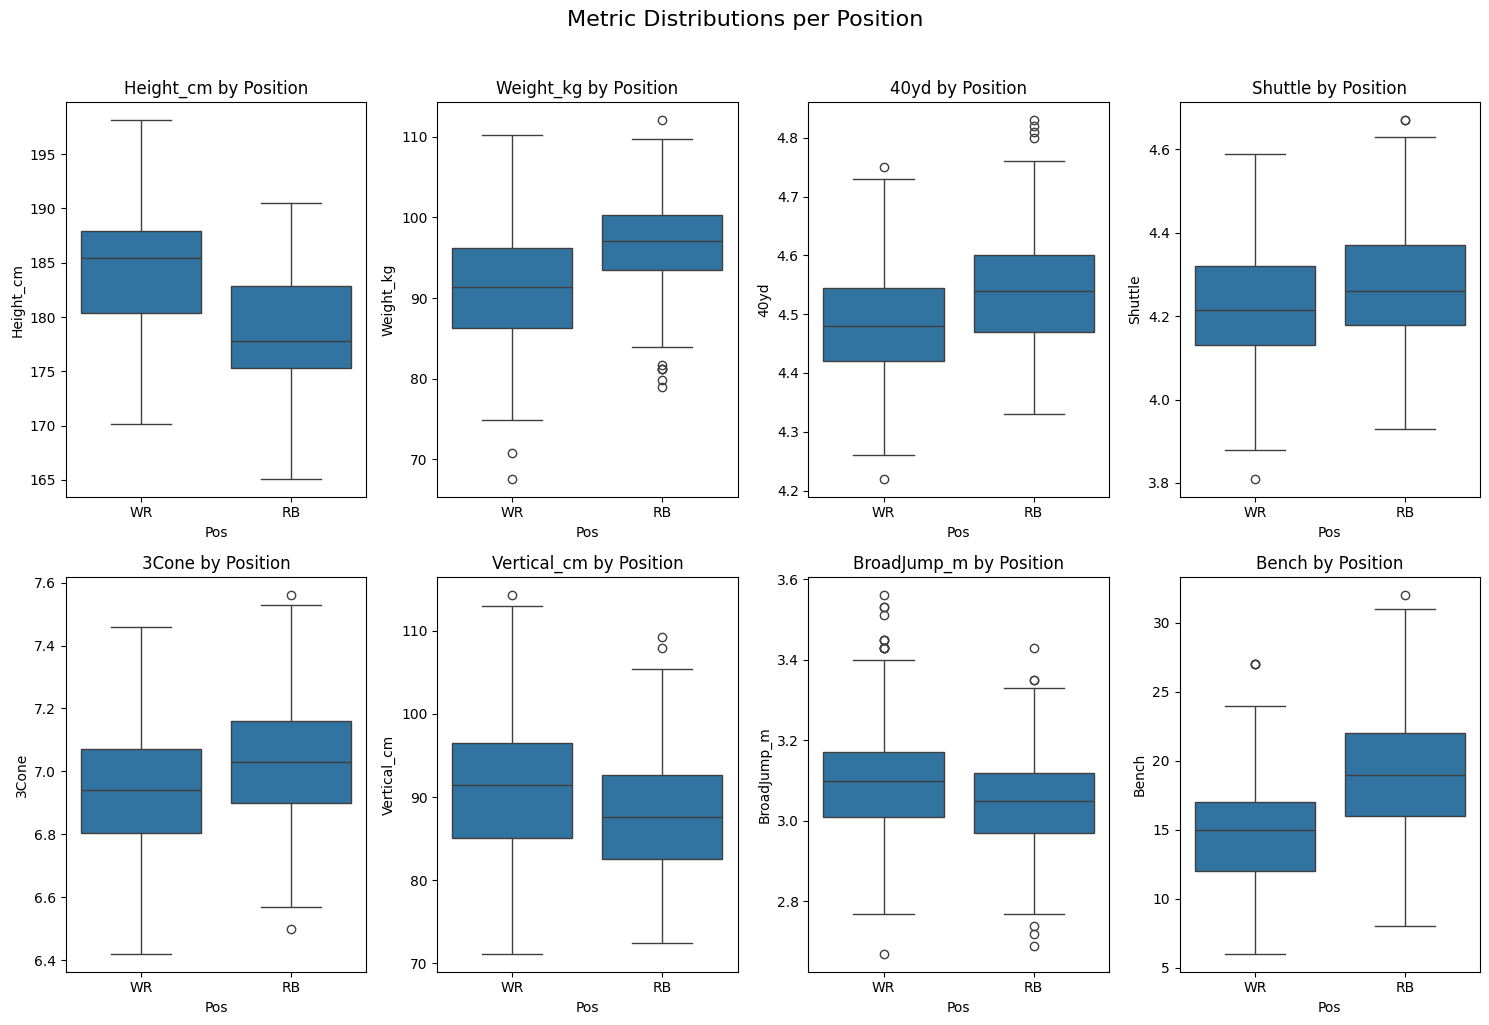

In [25]:
# Overview perfomance per discipline in each position
fig, axes = plt.subplots(2, 4, figsize=(15, 10))

metrics = ['Height_cm', 'Weight_kg', '40yd', 'Shuttle', '3Cone', 'Vertical_cm', 'BroadJump_m', 'Bench']
positions = ['WR', 'RB']

for i, metric in enumerate(metrics):
    row, col = i // 4, i % 4
    sns.boxplot(x='Pos', y=metric, data=df_players_combine_unique[df_players_combine_unique['Pos'].isin(positions)], ax=axes[row, col])
    axes[row, col].set_title(f'{metric} by Position')


plt.suptitle('Metric Distributions per Position', fontsize=16, y=1.02)

plt.tight_layout()
plt.show()


In [26]:
# mean values for WR and RB for selected metrics
mean_Height_WR = df_players_combine_unique[df_players_combine_unique['Pos'] == 'WR']['Height_cm'].mean()
mean_Weight_WR = df_players_combine_unique[df_players_combine_unique['Pos'] == 'WR']['Weight_kg'].mean()
mean_40yd_WR = df_players_combine_unique[df_players_combine_unique['Pos'] == 'WR']['40yd'].mean()
mean_Shuttle_WR = df_players_combine_unique[df_players_combine_unique['Pos'] == 'WR']['Shuttle'].mean()
mean_3Cone_WR = df_players_combine_unique[df_players_combine_unique['Pos'] == 'WR']['3Cone'].mean()
mean_Vertical_WR = df_players_combine_unique[df_players_combine_unique['Pos'] == 'WR']['Vertical_cm'].mean()
mean_Broadjump_WR = df_players_combine_unique[df_players_combine_unique['Pos'] == 'WR']['BroadJump_m'].mean()
mean_Bench_WR = df_players_combine_unique[df_players_combine_unique['Pos'] == 'WR']['Bench'].mean()

mean_Height_RB = df_players_combine_unique[df_players_combine_unique['Pos'] == 'RB']['Height_cm'].mean()
mean_Weight_RB = df_players_combine_unique[df_players_combine_unique['Pos'] == 'RB']['Weight_kg'].mean()
mean_40yd_RB = df_players_combine_unique[df_players_combine_unique['Pos'] == 'RB']['40yd'].mean()
mean_Shuttle_RB = df_players_combine_unique[df_players_combine_unique['Pos'] == 'RB']['Shuttle'].mean()
mean_3Cone_RB = df_players_combine_unique[df_players_combine_unique['Pos'] == 'RB']['3Cone'].mean()
mean_Vertical_RB = df_players_combine_unique[df_players_combine_unique['Pos'] == 'RB']['Vertical_cm'].mean()
mean_Broadjump_RB = df_players_combine_unique[df_players_combine_unique['Pos'] == 'RB']['BroadJump_m'].mean()
mean_Bench_RB = df_players_combine_unique[df_players_combine_unique['Pos'] == 'RB']['Bench'].mean()



# differences of means
diff_Height = mean_Height_WR - mean_Height_RB
diff_Weight = mean_Weight_WR - mean_Weight_RB
diff_40yd = mean_40yd_WR - mean_40yd_RB
diff_Shuttle = mean_Shuttle_WR - mean_Shuttle_RB
diff_3Cone = mean_3Cone_WR - mean_3Cone_RB
diff_Vertical = mean_Vertical_WR - mean_Vertical_RB
diff_Broadjump = mean_Broadjump_WR - mean_Broadjump_RB
diff_Bench = mean_Bench_WR - mean_Bench_RB

# print(f"Height difference: {diff_Height:.2f} cm")
# print(f"Weight difference: {diff_Weight:.2f} kg")
# print(f"40-yard dash difference: {diff_40yd:.2f} seconds")
# print(f"Shuttle difference: {diff_Shuttle:.2f} seconds")
# print(f"3 Cone drill difference: {diff_3Cone:.2f} seconds")
# print(f"Vertical jump difference: {diff_Vertical:.2f} cm")
# print(f"Broad jump difference: {diff_Broadjump:.2f} m")
# print(f"Bench press difference: {diff_Bench:.2f} reps")



The extent to which the characteristics of the positions can differ can be seen by looking at all the values broken down by the wide receiver and running back positions. Both positions can be assigned to the offense, but the Combine performance data shows clear differences, because: Offense is not the same as offense.

Wide receivers have a larger body size and combine this with enormous sprinting power. Typical characteristics for a player who has to catch the balls thrown by the quarterback.
A running back, on the other hand, has his strengths in agility and speed paired with strength, as his task is to gain a lot of ground with the ball and advance into the end zone. 

- **Wide receivers** are on average **5.4 cm taller** than running backs and reach an average of **3.3 cm more height** with their jumping power.

- **Running backs** achieve **faster times in speed** tests with their average **5.4 kg lighter** weight and achieve an average of **5 repetitions more** in the bench press.


The comparison of the data distribution of the Combine values shows precisely these characteristics for each position. Due to the strong position dependency, we focus specifically on the position of the wide receiver in the following report.

In [27]:
#Create a dataframe per Position
filtered_data_WR = df_players_combine_unique[df_players_combine_unique['Pos'] == 'WR']
filtered_data_RB = df_players_combine_unique[df_players_combine_unique['Pos'] == 'RB']

In [28]:
# # Metric Distributions for Wide Receiver (Mean and Quantiles)
# metrics = ['Height_cm', 'Weight_kg', '40yd', 'Shuttle', '3Cone', 'Vertical_cm', 'BroadJump_m', 'Bench']

# # Set up the plot grid, 2 rows and 3 columns
# fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# # Create a scatter plot for each metric
# for i, metric in enumerate(metrics):
#     row, col = i // 4, i % 4  # Determine subplot position
#     ax = axes[row, col]
    
#     # Count the number of occurrences of each value in the metric column
#     value_counts = filtered_data_WR[metric].value_counts().reset_index()
#     value_counts.columns = ['metric_value', 'count']
    
#     # Create scatter plot
#     sns.scatterplot(x='metric_value', y='count', data=value_counts, ax=ax, color='blue', s=100)
    
#     # Calculate mean and quantiles
#     mean_val = filtered_data_WR[metric].mean()
#     lower_quantile = filtered_data_WR[metric].quantile(0.25)
#     upper_quantile = filtered_data_WR[metric].quantile(0.75)
    
#     # Add red line for the mean
#     ax.axvline(mean_val, color='red', linestyle='-', label='Mean', linewidth=2)
    
#     # Add dotted lines for the quantiles
#     ax.axvline(lower_quantile, color='green', linestyle='--', label='25th Percentile', linewidth=2)
#     ax.axvline(upper_quantile, color='orange', linestyle='--', label='75th Percentile', linewidth=2)
    
#     # Set titles and labels
#     ax.set_title(f'{metric} Distribution (WR)')
#     ax.set_xlabel(f'{metric}')
#     ax.set_ylabel('Count')
    
#     # Show legend
#     ax.legend()

# plt.suptitle('Metric Distributions for Wide Receiver (Mean and Quantiles)', fontsize=20, y=1.02)
# plt.tight_layout()
# plt.show()

In [29]:
# # Metric Distributions for Running Backs (Mean and Quantiles)
# metrics = ['Height_cm', 'Weight_kg', '40yd', 'Shuttle', '3Cone', 'Vertical_cm', 'BroadJump_m', 'Bench']

# # Set up the plot grid, 2 rows and 3 columns
# fig, axes = plt.subplots(2, 4, figsize=(20, 8))

# # Create a scatter plot for each metric
# for i, metric in enumerate(metrics):
#     row, col = i // 4, i % 4  # Determine subplot position
#     ax = axes[row, col]
    
#     # Count the number of occurrences of each value in the metric column
#     value_counts = filtered_data_RB[metric].value_counts().reset_index()
#     value_counts.columns = ['metric_value', 'count']
    
#     # Create scatter plot
#     sns.scatterplot(x='metric_value', y='count', data=value_counts, ax=ax, color='blue', s=100)
    
#     # Calculate mean and quantiles
#     mean_val = filtered_data_RB[metric].mean()
#     lower_quantile = filtered_data_RB[metric].quantile(0.25)
#     upper_quantile = filtered_data_RB[metric].quantile(0.75)
    
#     # Add red line for the mean
#     ax.axvline(mean_val, color='red', linestyle='-', label='Mean', linewidth=2)
    
#     # Add dotted lines for the quantiles
#     ax.axvline(lower_quantile, color='green', linestyle='--', label='25th Percentile', linewidth=2)
#     ax.axvline(upper_quantile, color='orange', linestyle='--', label='75th Percentile', linewidth=2)
    
#     # Set titles and labels
#     ax.set_title(f'{metric} Distribution (RB)')
#     ax.set_xlabel(f'{metric}')
#     ax.set_ylabel('Count')
    
#     # Show legend
#     ax.legend()

# plt.suptitle('Metric Distributions for Running Backs (Mean and Quantiles)', fontsize=20, y=1.02)

# plt.tight_layout()
# plt.show()


As found in the first study above, wide receivers are significantly taller. This is no coincidence, because height is a decisive factor for this position, as confirmed in an interview with Darius Willis, former college player, coach of the Helvetic Guards and football data analyst: “Height is a decisive factor.... But the key question is: What does jumping power or speed look like with a larger body size? If the player is rather small and is used in the offense, he has to be some kind of utility weapon with explosiveness and agility to create danger on the opposing side.”

Let us therefore take a closer look at the Combine results for wide receivers and examine the influence of body size on the individual metrics.

In [30]:
# # Calculate correlation between metrics for players
# correlation_matrix = filtered_data_WR[['Weight_kg', 'Height_cm', '40yd', 'Shuttle', '3Cone', 'Vertical_cm', 'BroadJump_m', 'Bench']].corr()

# # Plot the heatmap
# plt.figure(figsize=(10, 6))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
# plt.title('Correlation Heatmap: Physical Attributes vs Performance')
# plt.show()

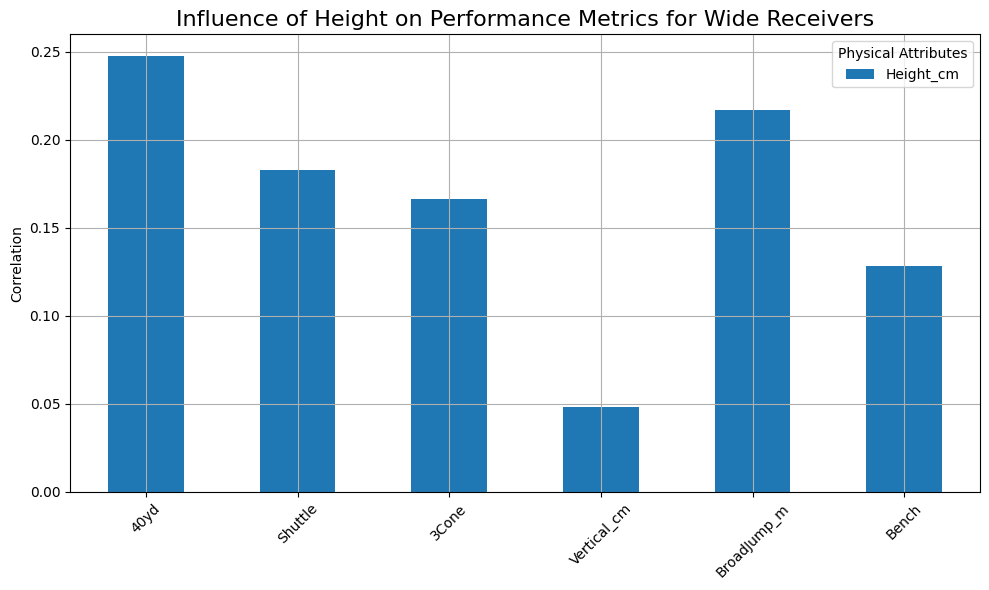

In [31]:
# Calculate the correlation matrix
correlation_matrix = filtered_data_WR[['Height_cm', '40yd', 'Shuttle', '3Cone', 'Vertical_cm', 'BroadJump_m', 'Bench']].corr()

# Extract the correlations of Height and Weight with performance metrics
influence_matrix = correlation_matrix.loc[['Height_cm'], ['40yd', 'Shuttle', '3Cone', 'Vertical_cm', 'BroadJump_m', 'Bench']]

# Create a bar plot for easier comparison
influence_matrix.T.plot(kind='bar', figsize=(10, 6))

# Customize the plot
plt.title('Influence of Height on Performance Metrics for Wide Receivers', fontsize=16)
plt.ylabel('Correlation')
plt.xticks(rotation=45)
plt.grid()
plt.legend(title='Physical Attributes')
plt.tight_layout()

# Display the plot
plt.show()

It turns out that taller wide receivers tend to achieve slower times in tests in the areas of speed and agility. On the other hand, they tend to have better jumping ability and more power the taller they are.
Running backs with a large body size show a similar behavior on the results. However, the influence of body size is smaller, as running backs have fundamentally better characteristics in terms of speed and agility.

### Development of Combine performance

With the opening up of new markets through NFL games all over the world, the sport is becoming increasingly important: 
"The NFL’s international expansion strategy is not just about allocating market rights to clubs but also about hosting events and games abroad. For instance, the international game series and the project to introduce flag football in global markets are key efforts to increase engagement with the sport at the youth and community level." [altrianglobalsports.com, 2024]

This leads to a further professionalization of athletes at a young age. It would therefore be logical if the Combine performance values have improved over time. Let's take a look at the development of the Combine results of wide receivers over the last ten years.


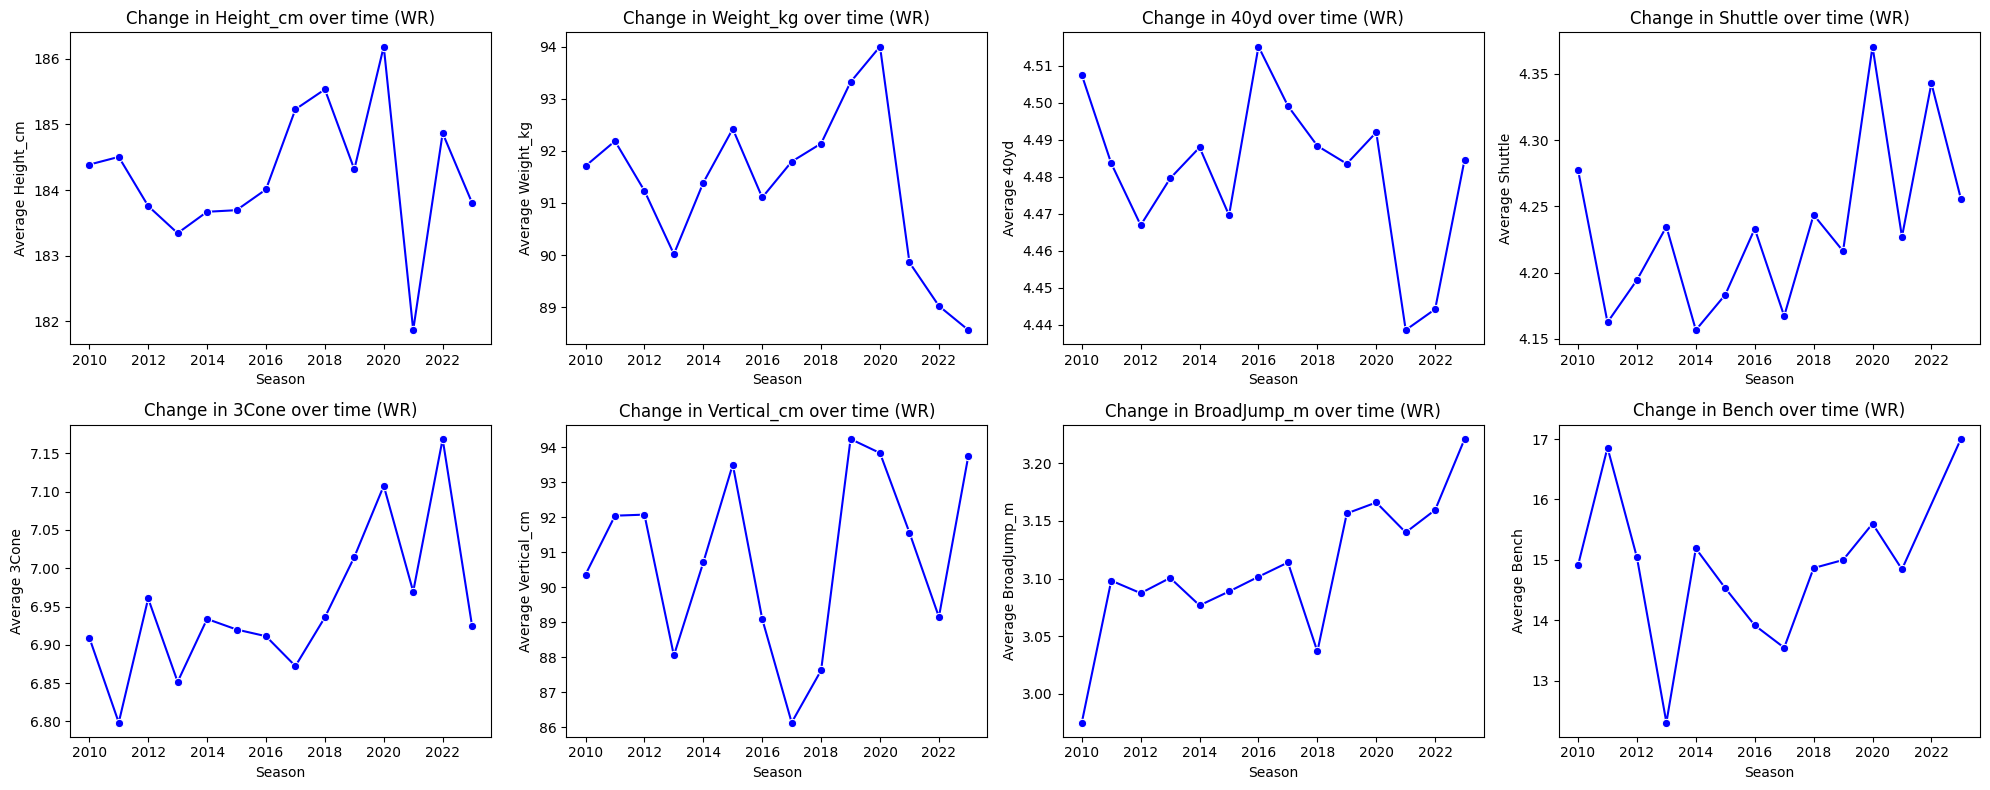

In [32]:
# Development of Combine performance over the last ten years
# Metrics to analyze
metrics = ['Height_cm', 'Weight_kg', '40yd', 'Shuttle', '3Cone', 'Vertical_cm', 'BroadJump_m', 'Bench']

# Group by 'season' and calculate mean for each metric
metrics_by_season = filtered_data_WR.groupby('season')[metrics].mean().reset_index()

# Set up the plot grid, 2 rows and 3 columns
fig, axes = plt.subplots(2, 4, figsize=(20, 8))

# Create a line plot for each metric to see how it changes over time
for i, metric in enumerate(metrics):
    row, col = i // 4, i % 4  # determine subplot position
    ax = axes[row, col]
    
    # Create line plot
    sns.lineplot(x='season', y=metric, data=metrics_by_season, ax=ax, marker="o", color='blue')
    
    # Add title and labels
    ax.set_title(f'Change in {metric} over time (WR)')
    ax.set_xlabel('Season')
    ax.set_ylabel(f'Average {metric}')

plt.tight_layout()
plt.show()

In [33]:
# # Development of Combine performance over the last ten years: Regression
# # Metrics to analyze
# metrics = ['Height_cm', 'Weight_kg', '40yd', 'Shuttle', '3Cone', 'Vertical_cm', 'BroadJump_m', 'Bench']

# # Set up the plot grid, 2 rows and 3 columns
# fig, axes = plt.subplots(2, 4, figsize=(20, 8))

# # Create a scatter plot with a regression line for each metric to see the trend over time
# for i, metric in enumerate(metrics):
#     row, col = i // 4, i % 4  # determine subplot position
#     ax = axes[row, col]
    
#     # Create scatter plot with regression line
#     sns.regplot(x='season', y=metric, data=filtered_data_WR, ax=ax, scatter_kws={'s': 10}, line_kws={"color": "red"})
    
#     # Add title and labels
#     ax.set_title(f'{metric} over time (WR)')
#     ax.set_xlabel('Season')
#     ax.set_ylabel(f'{metric}')

# plt.tight_layout()
# plt.show()

In [34]:
# # Trend analysis of the development
# # Metrics to analyze
# metrics = ['Height_cm', 'Weight_kg', '40yd', 'Shuttle', '3Cone', 'Vertical_cm', 'BroadJump_m', 'Bench']

# # Iterate over each metric to calculate and print the slope
# for metric in metrics:
#     # Drop rows where the metric or season is NaN
#     filtered_data = filtered_data_WR[['season', metric]].dropna()
    
#     # Perform linear regression to get the slope
#     slope, intercept, r_value, p_value, std_err = linregress(filtered_data['season'], filtered_data[metric])
    
#     # Print the slope for each metric
#     print(f"Slope of {metric} over time: {slope:.4f}")

A clear trend for improved values in one category cannot be identified. For certain categories, there are indications that there has been a minimal increase in the results achieved, but data from further back in time would have to be analysed to make a well-founded statement. This assumption is illustrated by various articles from the world of sport, including this article which looks at developments since 1985: http://thefanverdict.com/index.php/2019/03/11/the-nfl-draft-combine-evolution-of-the-modern-day-football-super-athlete/

### Top Performances: Combine

Finally, the interesting question: Who has achieved the best Combine results in these years? Let's take a look at the results of all players per category since the 2010 Combine.

In [53]:
# Make a copy of the original DataFrame to avoid modifying it
df_ranked = df_players_combine_unique.copy()

# Define metrics where higher is better (e.g., Vertical, BroadJump, Bench)
higher_is_better_metrics = ['Vertical_cm', 'BroadJump_m', 'Bench']

# Define metrics where lower is better (e.g., 40yd, Shuttle, 3Cone)
lower_is_better_metrics = ['40yd', 'Shuttle', '3Cone']

# Impute missing values with the mean of the respective metric based on the player's position
for metric in higher_is_better_metrics + lower_is_better_metrics:
    df_ranked[metric] = df_ranked.groupby('Pos')[metric].transform(lambda x: x.fillna(x.mean()))

# Rank players based on each metric (ensure no decimal values and handle NaNs)
for metric in higher_is_better_metrics:
    df_ranked[f'{metric}_rank'] = df_ranked[metric].rank(ascending=False, method='min')
    df_ranked[f'{metric}_rank'] = df_ranked[f'{metric}_rank'].fillna(df_ranked[f'{metric}_rank'].max() + 1).astype(int)  # Fill NaNs and cast to integer

for metric in lower_is_better_metrics:
    df_ranked[f'{metric}_rank'] = df_ranked[metric].rank(ascending=True, method='min')
    df_ranked[f'{metric}_rank'] = df_ranked[f'{metric}_rank'].fillna(df_ranked[f'{metric}_rank'].max() + 1).astype(int)  # Fill NaNs and cast to integer

# Calculate the mean rank across all metrics for each player (for overall performance)
df_ranked['mean_rank'] = df_ranked[[f'{metric}_rank' for metric in higher_is_better_metrics + lower_is_better_metrics]].mean(axis=1)

# Assign overall rank based on the mean rank, where lowest mean rank gets the best overall rank (1, 2, 3,...)
df_ranked['overall_rank'] = df_ranked['mean_rank'].rank(ascending=True, method='min').astype(int)

# Sort by overall rank to get the best overall performers
df_ranked_sorted = df_ranked.sort_values(by='overall_rank')

# Get the top 10 for each metric and the overall rank
top_10_40yd = df_ranked_sorted.sort_values(by='40yd_rank').head(10)[['player_name', '40yd', '40yd_rank']]
top_10_Shuttle = df_ranked_sorted.sort_values(by='Shuttle_rank').head(10)[['player_name', 'Shuttle', 'Shuttle_rank']]
top_10_3Cone = df_ranked_sorted.sort_values(by='3Cone_rank').head(10)[['player_name', '3Cone', '3Cone_rank']]
top_10_Vertical = df_ranked_sorted.sort_values(by='Vertical_cm_rank').head(10)[['player_name', 'Vertical_cm', 'Vertical_cm_rank']]
top_10_BroadJump = df_ranked_sorted.sort_values(by='BroadJump_m_rank').head(10)[['player_name', 'BroadJump_m', 'BroadJump_m_rank']]
top_10_Bench = df_ranked_sorted.sort_values(by='Bench_rank').head(10)[['player_name', 'Bench', 'Bench_rank']]
top_10_overall = df_ranked_sorted.head(10)[['player_name', 'overall_rank']]

# Display the top 10 for each metric and overall performers
# print("\nTop 10 players in 40 Yard Dash:")
# print(top_10_40yd)

# print("\nTop 10 players in Shuttle:")
# print(top_10_Shuttle)

# print("\nTop 10 players in 3Cone Drill:")
# print(top_10_3Cone)

# print("\nTop 10 players in Vertical Jump:")
# print(top_10_Vertical)

# print("\nTop 10 players in Broad Jump:")
# print(top_10_BroadJump)

# print("\nTop 10 players in Bench Press:")
# print(top_10_Bench)

# print("\nTop 10 overall performers (Rank based on mean of all ranks):")
print(top_10_overall)




             player_name  overall_rank
9145     Jerick McKinnon             1
5935         Chris Owusu             2
7675   Christine Michael             3
4927        Torrey Smith             4
10365      Sammie Coates             5
4368         Taylor Mays             6
8423          Jeff Janis             7
4951         Greg Little             8
12857       Mike Gesicki             9
10127     Ameer Abdullah            10


In [36]:
# Make sure the sorted DataFrame is up to date
# df_ranked_sorted should already be sorted based on overall rank

# 1. Find the latest top performances for each metric
# Extract relevant columns including the year or date if available (assuming 'year' or similar column exists)
top_performances = {
    '40yd': df_ranked_sorted[df_ranked_sorted['40yd_rank'] == 1][['player_name', 'Pos', '40yd', 'season']].sort_values(by='season', ascending=False).iloc[0],
    'Shuttle': df_ranked_sorted[df_ranked_sorted['Shuttle_rank'] == 1][['player_name', 'Pos', 'Shuttle', 'season']].sort_values(by='season', ascending=False).iloc[0],
    '3Cone': df_ranked_sorted[df_ranked_sorted['3Cone_rank'] == 1][['player_name', 'Pos', '3Cone', 'season']].sort_values(by='season', ascending=False).iloc[0],
    'Vertical_cm': df_ranked_sorted[df_ranked_sorted['Vertical_cm_rank'] == 1][['player_name', 'Pos', 'Vertical_cm', 'season']].sort_values(by='season', ascending=False).iloc[0],
    'BroadJump_m': df_ranked_sorted[df_ranked_sorted['BroadJump_m_rank'] == 1][['player_name', 'Pos', 'BroadJump_m', 'season']].sort_values(by='season', ascending=False).iloc[0],
    'Bench': df_ranked_sorted[df_ranked_sorted['Bench_rank'] == 1][['player_name', 'Pos', 'Bench', 'season']].sort_values(by='season', ascending=False).iloc[0]
}

# Display the latest top values for each metric
# print("Latest Top Performances by Metric:")
# for metric, row in top_performances.items():
#     print(f"{metric}: {row['player_name']} (Position: {row['Pos']}) achieved {row[metric]} in {row['season']}")

# 2. Find the best WR (wide receiver) based on overall rating
best_wr = df_ranked_sorted[df_ranked_sorted['Pos'] == 'WR'].sort_values(by='overall_rank').iloc[0]
# print(f"\nBest WR based on overall rating: {best_wr['player_name']} with an overall rank of {best_wr['overall_rank']}")


In [37]:
# Find the best WR (wide receiver) based on overall rating
best_wr = df_ranked_sorted[df_ranked_sorted['Pos'] == 'WR'].sort_values(by='overall_rank').iloc[0]

# Print a detailed overview of the best WR's achievements
# print(f"\nBest WR based on overall rating: {best_wr['player_name']} with an overall rank of {best_wr['overall_rank']}\n")

# Extract and display all relevant performance values for the best WR
wr_achievements = {
    'Position': best_wr['Pos'],
    'Height (cm)': best_wr['Height_cm'],
    'Weight (kg)': best_wr['Weight_kg'],
    '40 Yard Dash (sec)': best_wr['40yd'],
    'Shuttle (sec)': best_wr['Shuttle'],
    '3Cone Drill (sec)': best_wr['3Cone'],
    'Vertical Jump (cm)': best_wr['Vertical_cm'],
    'Broad Jump (m)': best_wr['BroadJump_m'],
    'Bench Press (reps)': best_wr['Bench'],
    '40yd Rank': best_wr['40yd_rank'],
    'Shuttle Rank': best_wr['Shuttle_rank'],
    '3Cone Rank': best_wr['3Cone_rank'],
    'Vertical Jump Rank': best_wr['Vertical_cm_rank'],
    'Broad Jump Rank': best_wr['BroadJump_m_rank'],
    'Bench Rank': best_wr['Bench_rank'],
    'Overall Mean Rank': best_wr['mean_rank'],
    'Overall Rank': best_wr['overall_rank'],
}

# Print all values in a readable format
# print("Achievements of the Best WR:")
# for metric, value in wr_achievements.items():
#     print(f"{metric}: {value}")


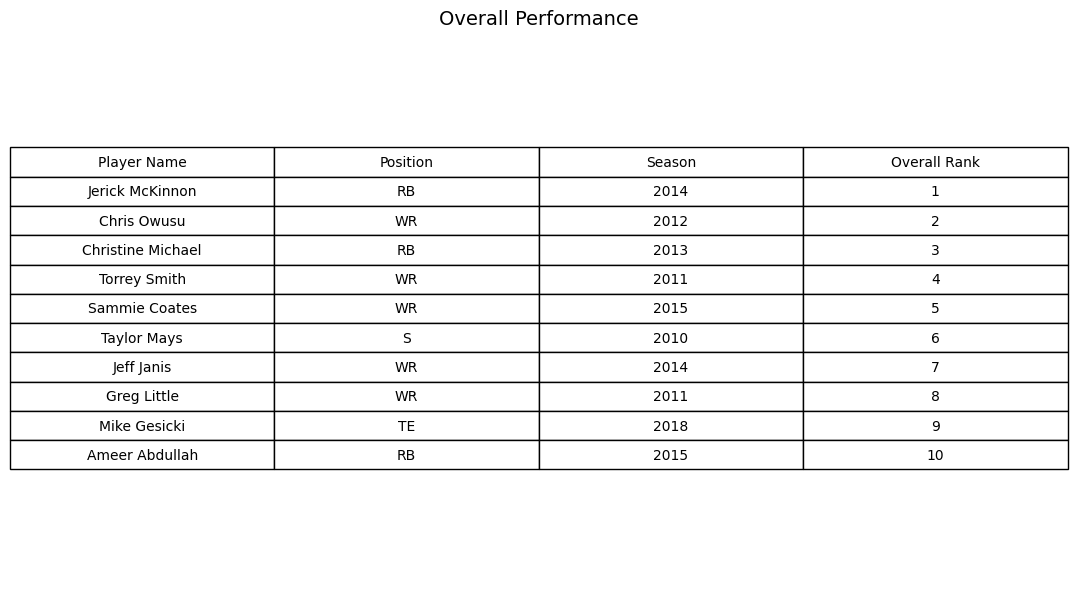

In [38]:
# Add 'Position' and 'Season' to the top_10_overall DataFrame
top_10_overall = df_ranked_sorted.head(10)[['player_name', 'Pos', 'season', 'overall_rank']]

# Function to create table for a specific metric
def create_table(ax, df, metric_name, column_labels):
    ax.axis('off')  # Turn off the axis

    # Create the table and display it
    table = ax.table(cellText=df.values, colLabels=column_labels, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.5, 1.5)  # Adjust the scaling for better visibility
    ax.set_title(metric_name, fontsize=14, pad=10)

# Create a 1x1 subplot layout since we're only displaying the overall ranking table
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the figure size as needed

# Plot the overall ranking table with added columns
create_table(ax, top_10_overall, "Overall Performance", ['Player Name', 'Position', 'Season', 'Overall Rank'])

# Display the table
plt.tight_layout()
plt.show()

# The following code is kept for computation but commented out for plotting purposes

# # Create a 2x4 subplot layout for other metrics (not displayed)
# fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # Adjust the figure size as needed
# fig.tight_layout(pad=5)  # Adjust the padding between plots

# # Plot each of the top 10 tables in the grid (commented out)
# create_table(axes[0, 0], top_10_40yd, "40 Yard Dash", ['Player Name', '40 Yard Time', 'Rank'])
# create_table(axes[0, 1], top_10_Shuttle, "Shuttle", ['Player Name', 'Shuttle Time', 'Rank'])
# create_table(axes[0, 2], top_10_3Cone, "3Cone Drill", ['Player Name', '3Cone Time', 'Rank'])
# create_table(axes[0, 3], top_10_Vertical, "Vertical Jump", ['Player Name', 'Vertical Jump (cm)', 'Rank'])
# create_table(axes[1, 0], top_10_BroadJump, "Broad Jump", ['Player Name', 'Broad Jump (m)', 'Rank'])
# create_table(axes[1, 1], top_10_Bench, "Bench Press", ['Player Name', 'Bench Reps', 'Rank'])

# # Remove any unused subplot (axes[1, 3] is unused)
# axes[1, 3].axis('off')

# # Display the grid of tables (not executed)
# plt.show()





It is interesting to note that many of the best values in the 2010 to 2023 were achieved by wide receiver positions. Only the best values of the 3cone test and bench press are led by other positions. It is therefore not surprising that a wide receiver can be found in second place in the overall rating. This athlete is Chris Owusu. The performances of the season are analyzed below and who knows, maybe the athlete will appear among the top performers again and possible conclusions can be drawn between the Combine values and the season performances? Let's take a look.

## Seasonal Performance

In this chapter we look at the performances of football players in the seasons they have played. This means that you can measure the performance of the games, how well they played and accordingly how much they helped a team. We focus on wide receivers in this analysis because they are easier to measure and we have more data points in our Combine dataset than other positions.

In [39]:
# Load the data
df_player_fulldata = pd.read_csv('../00_Data/players_2010_2023.csv')

# Split the data into Position group Wide Receiver
df_wide_receivers = df_player_fulldata[df_player_fulldata["position"] == "WR"].copy()  # Make a copy to avoid SettingWithCopyWarning

# Add the seasons_played column
# Group by 'player_name' and count unique 'season' values
df_wide_receivers.loc[:, 'seasons_played'] = df_wide_receivers.groupby('player_name')['season'].transform('nunique')

### Player Seasonal Statistics


In the first step, we analyse how the receivers performed in the respective years. To do this, we take the average of all players per year in order to be able to draw conclusions about differences between the seasons. The following 4 variables are analysed as metrics to measure the performance of the wide receivers:
1. Receptions
   - This refers to the number of successful catches made by a player. Receptions are crucial for evaluating a receiver's reliability in catching passes during games.

2. Receiving Touchdowns (TDs)
   - This metric shows the number of times a player scores a touchdown after catching a pass. It's an essential measure of a player's ability to turn receptions into points.

3. Receiving Yards
   - This metric indicates the total distance (in yards) a player gains with a catched ball. It reflects the player’s ability to make significant yardage on each reception.

4. Receiving Yards After Catch (YAC)
   - This measures how many yards a player gains after catching the ball, which highlights the player's ability to make plays once they have possession.


In [40]:
# calculate the average per season and store it in a variable
columns_to_average = [
    'receptions', 'targets', 'receiving_yards', 'receiving_tds', 
    'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards', 
    'receiving_yards_after_catch'
]

# Group by the 'season' column and calculate the mean for the selected columns
df_seasonal_averages = df_wide_receivers.groupby('season')[columns_to_average].mean().reset_index()


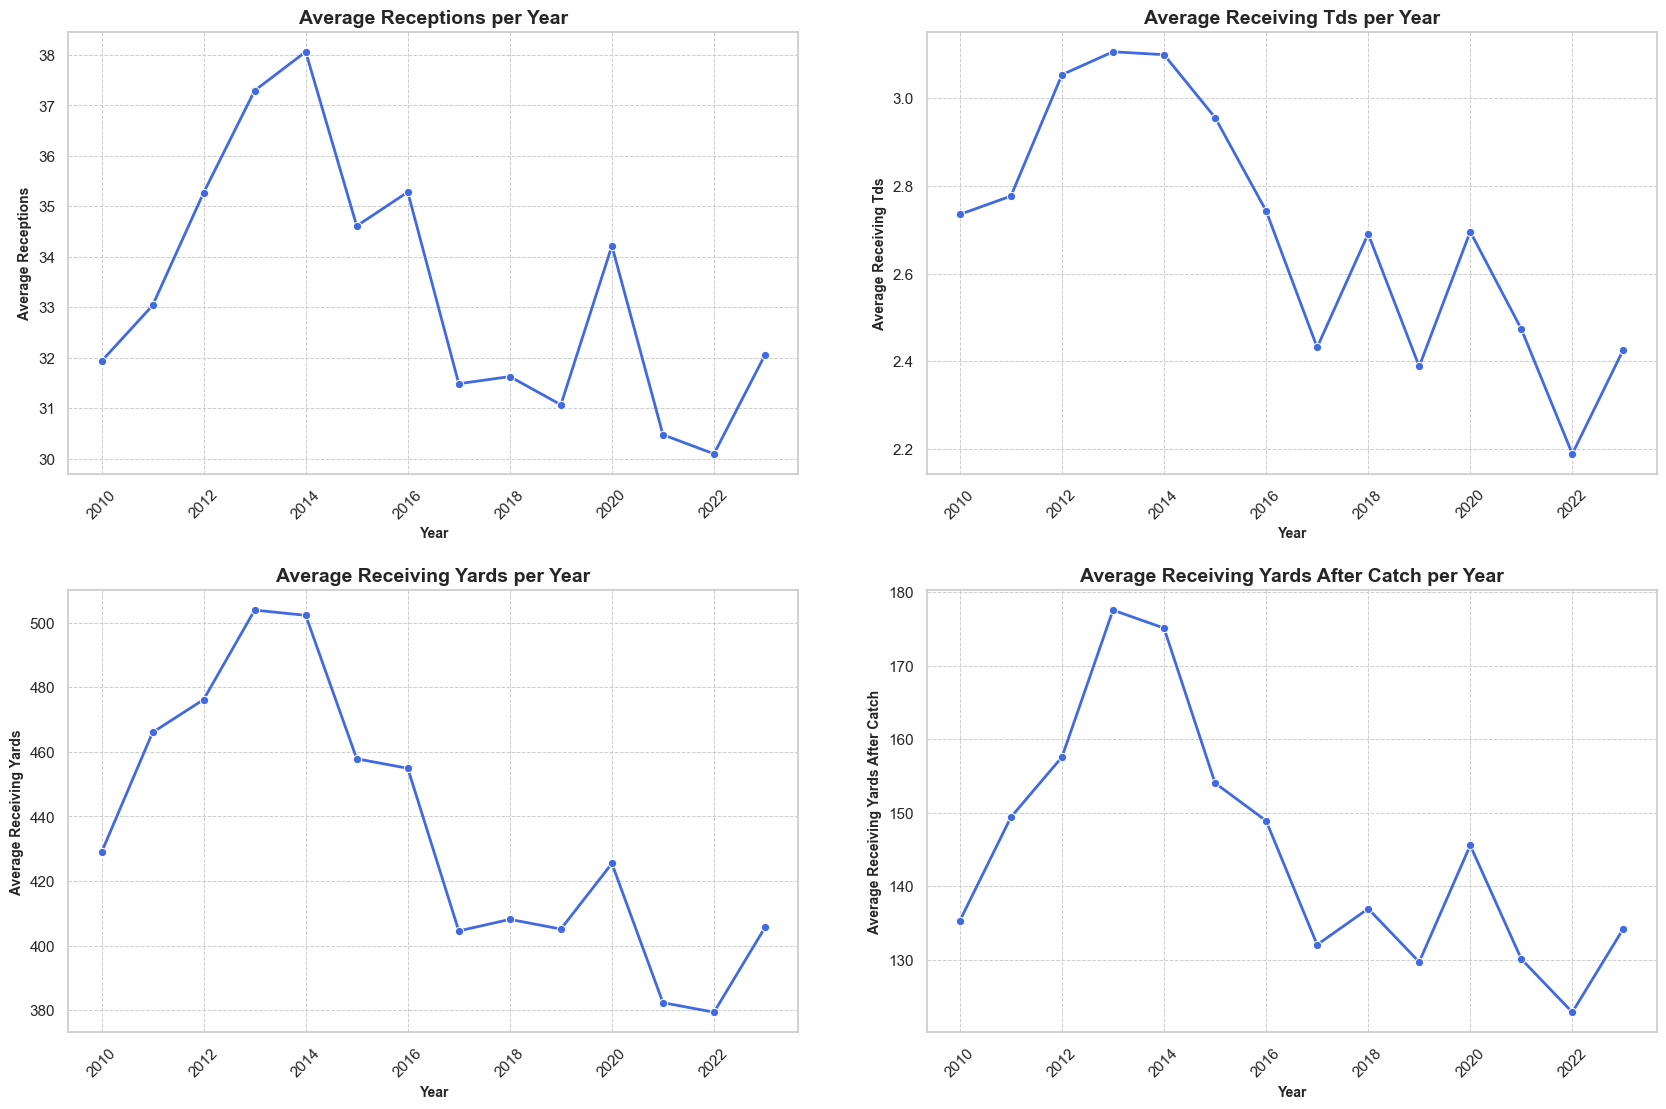

In [41]:
# Display the 4 Performance Metrics as a Graph over all Seasons

# Set Seaborn style for better aesthetics
sns.set_theme(style='whitegrid')  # Use a whitegrid theme

# Define the list of columns you want to plot (adjustable)
columns_to_plot = ['receptions', 'receiving_tds', 'receiving_yards', 
                    'receiving_yards_after_catch']

# Set the grid dimensions (3 rows, 3 columns)
rows = 2
cols = 2

# Create the subplots grid
fig, axes = plt.subplots(rows, cols, figsize=(18, 12))  # Adjust the size to fit all plots
fig.tight_layout(pad=5.0)  # Adjust spacing between plots

# Flatten the axes array to easily index it
axes = axes.flatten()

# Loop over each column and create the corresponding plot in the grid
for i, column in enumerate(columns_to_plot):
    sns.lineplot(x='season', y=column, data=df_seasonal_averages, 
                 marker='o', color='royalblue', linewidth=2, ax=axes[i])  # Add the plot to the corresponding subplot

    # Customize the plot
    axes[i].set_title(f'Average {column.replace("_", " ").title()} per Year', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Year', fontsize=10, fontweight='bold')
    axes[i].set_ylabel(f'Average {column.replace("_", " ").title()}', fontsize=10, fontweight='bold')
    axes[i].tick_params(axis='x', rotation=45)  # Rotate the x-axis labels if needed
    axes[i].grid(True, which='both', linestyle='--', linewidth=0.7)

# Hide any unused subplots (if there are fewer than grid size)
for j in range(i+1, rows*cols):
    fig.delaxes(axes[j])

# Show the grid of plots
plt.show()

You can clearly see a negative trend here. This means that in the 2012-2014 seasons, performance was higher on average than in the following years. It is difficult to draw any conclusions from the data, but this could indicate a better distribution among more people, for example. Of course, this has the effect of lowering the average per person. But it could also indicate a shift towards the running game or better defence, which has developed in these years. It does not necessarily indicate a poorer performance of the individual players.

### Comparison drafted vs not drafted

Here, the difference between the drafted players' average and the average of all players is presented.

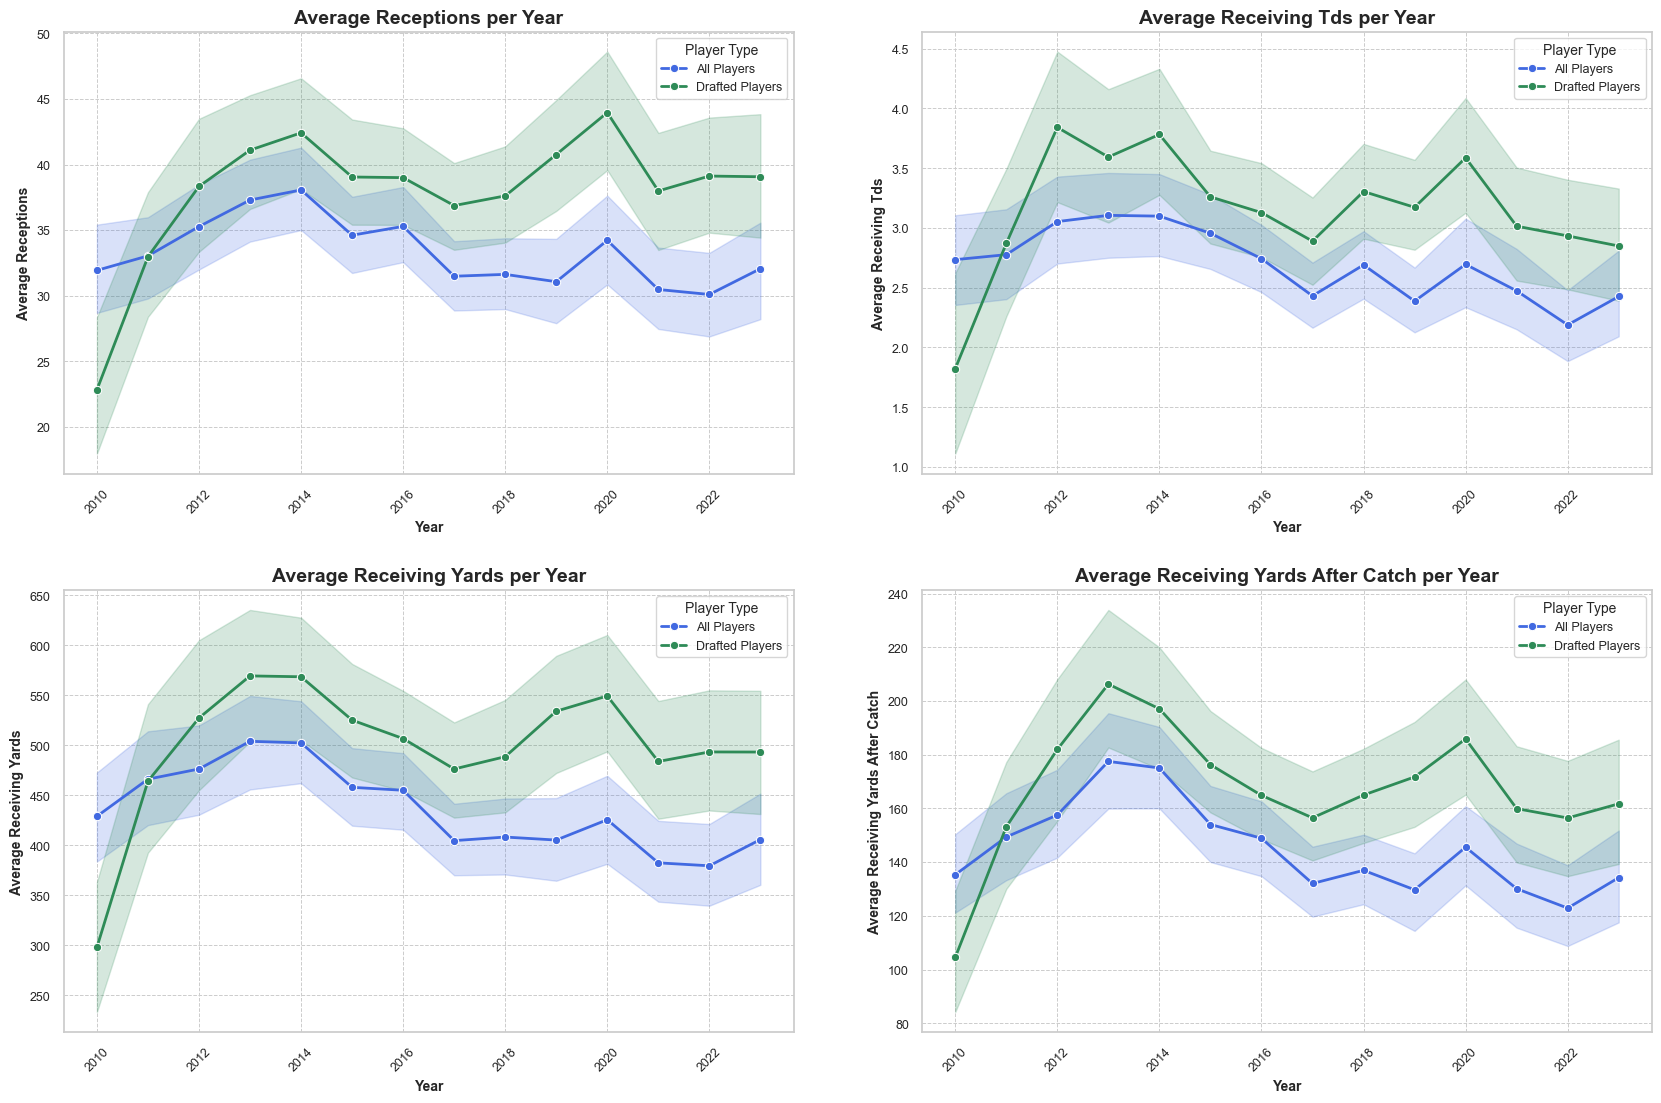

In [42]:
# Plot the performance of the Drafted Players vs all players

# Set Seaborn style for better aesthetics
sns.set_theme(style='whitegrid')  # Using whitegrid theme

# Filter the data to include only players where drafted = True
drafted_players = df_wide_receivers[df_wide_receivers['Drafted'] == True]

# Define the list of columns you want to plot (adjustable)
columns_to_plot = ['receptions', 'receiving_tds', 'receiving_yards', 
                   'receiving_yards_after_catch']

# Set the grid dimensions (3 rows, 3 columns)
rows = 2
cols = 2

# Create the subplots grid
fig, axes = plt.subplots(rows, cols, figsize=(18, 12))  # Adjust the size to fit all plots
fig.tight_layout(pad=5.0)  # Adjust spacing between plots

# Flatten the axes array to easily index it
axes = axes.flatten()

# Loop over each column and create the corresponding plot in the grid
for i, column in enumerate(columns_to_plot):
    # Plot for all players
    sns.lineplot(x='season', y=column, data=df_wide_receivers, 
                 marker='o', color='royalblue', linewidth=2, label='All Players', ax=axes[i])
    
    # Plot for drafted players only
    sns.lineplot(x='season', y=column, data=drafted_players, 
                 marker='o', color='seagreen', linewidth=2, label='Drafted Players', ax=axes[i])
    
    # Customize the plot with bold titles and labels
    axes[i].set_title(f'Average {column.replace("_", " ").title()} per Year', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Year', fontsize=10, fontweight='bold')
    axes[i].set_ylabel(f'Average {column.replace("_", " ").title()}', fontsize=10, fontweight='bold')
    axes[i].tick_params(axis='x', rotation=45, labelsize=9)  # Rotate the x-axis labels if needed
    axes[i].tick_params(axis='y', labelsize=9)
    
    # Customize the grid lines
    axes[i].grid(True, which='both', linestyle='--', linewidth=0.7)
    
    # Add a legend to distinguish between drafted and all players
    axes[i].legend(title='Player Type', title_fontsize='10', fontsize='9')

# Hide any unused subplots (if there are fewer than grid size)
for j in range(i+1, rows*cols):
    fig.delaxes(axes[j])

# Show the grid of plots
plt.show()



You can see a similar picture here in all views. On average, the drafted players are always better than the average of all players. Only in 2010 is this different. However, this is due to the number of players who were drafted in this year and because no data from previously drafted players can be found in the dataset. A truly reliable comparison can therefore only be made from a later season onwards. Based on these results, there really can be a correlation between a good performance at the Combine and later performance in the NFL. However, the question remains as to whether only physical performance is decisive here or whether other factors also play a role.

### Player Career Statistics

In this chapter we look at the comparison of players as an average of overall performance in the NFL. This makes it easier to compare performances, as not all players play the same amount of time in the NFL.

In [43]:
# Calculate the average per Player and store it in a variable
columns_to_average = [
    'seasons_played', 'receptions', 'targets', 'receiving_yards', 'receiving_tds', 
    'receiving_fumbles', 'receiving_fumbles_lost', 'receiving_air_yards', 
    'receiving_yards_after_catch','Pos', 'School', 'Height', 'Weight', 
    '40yd', 'Vertical', 'Bench', 'Broad Jump', '3Cone', 'Shuttle', 'Drafted', 'Round', 'Pick'
]

# Group by the 'season' column and calculate the mean for the selected columns
df_player_averages = df_wide_receivers.groupby(['first_year', 'player_name'])[columns_to_average].mean(numeric_only=True).reset_index()

In [44]:
# Define the columns for the combine relevant data and for the season performance data
combine_columns = ['Height', 'Weight', '40yd', 'Vertical', 'Bench', 'Broad Jump', '3Cone', 'Shuttle']
season_columns =  ['seasons_played', 'receptions', 'receiving_tds', 'receiving_yards', 'receiving_yards_after_catch']

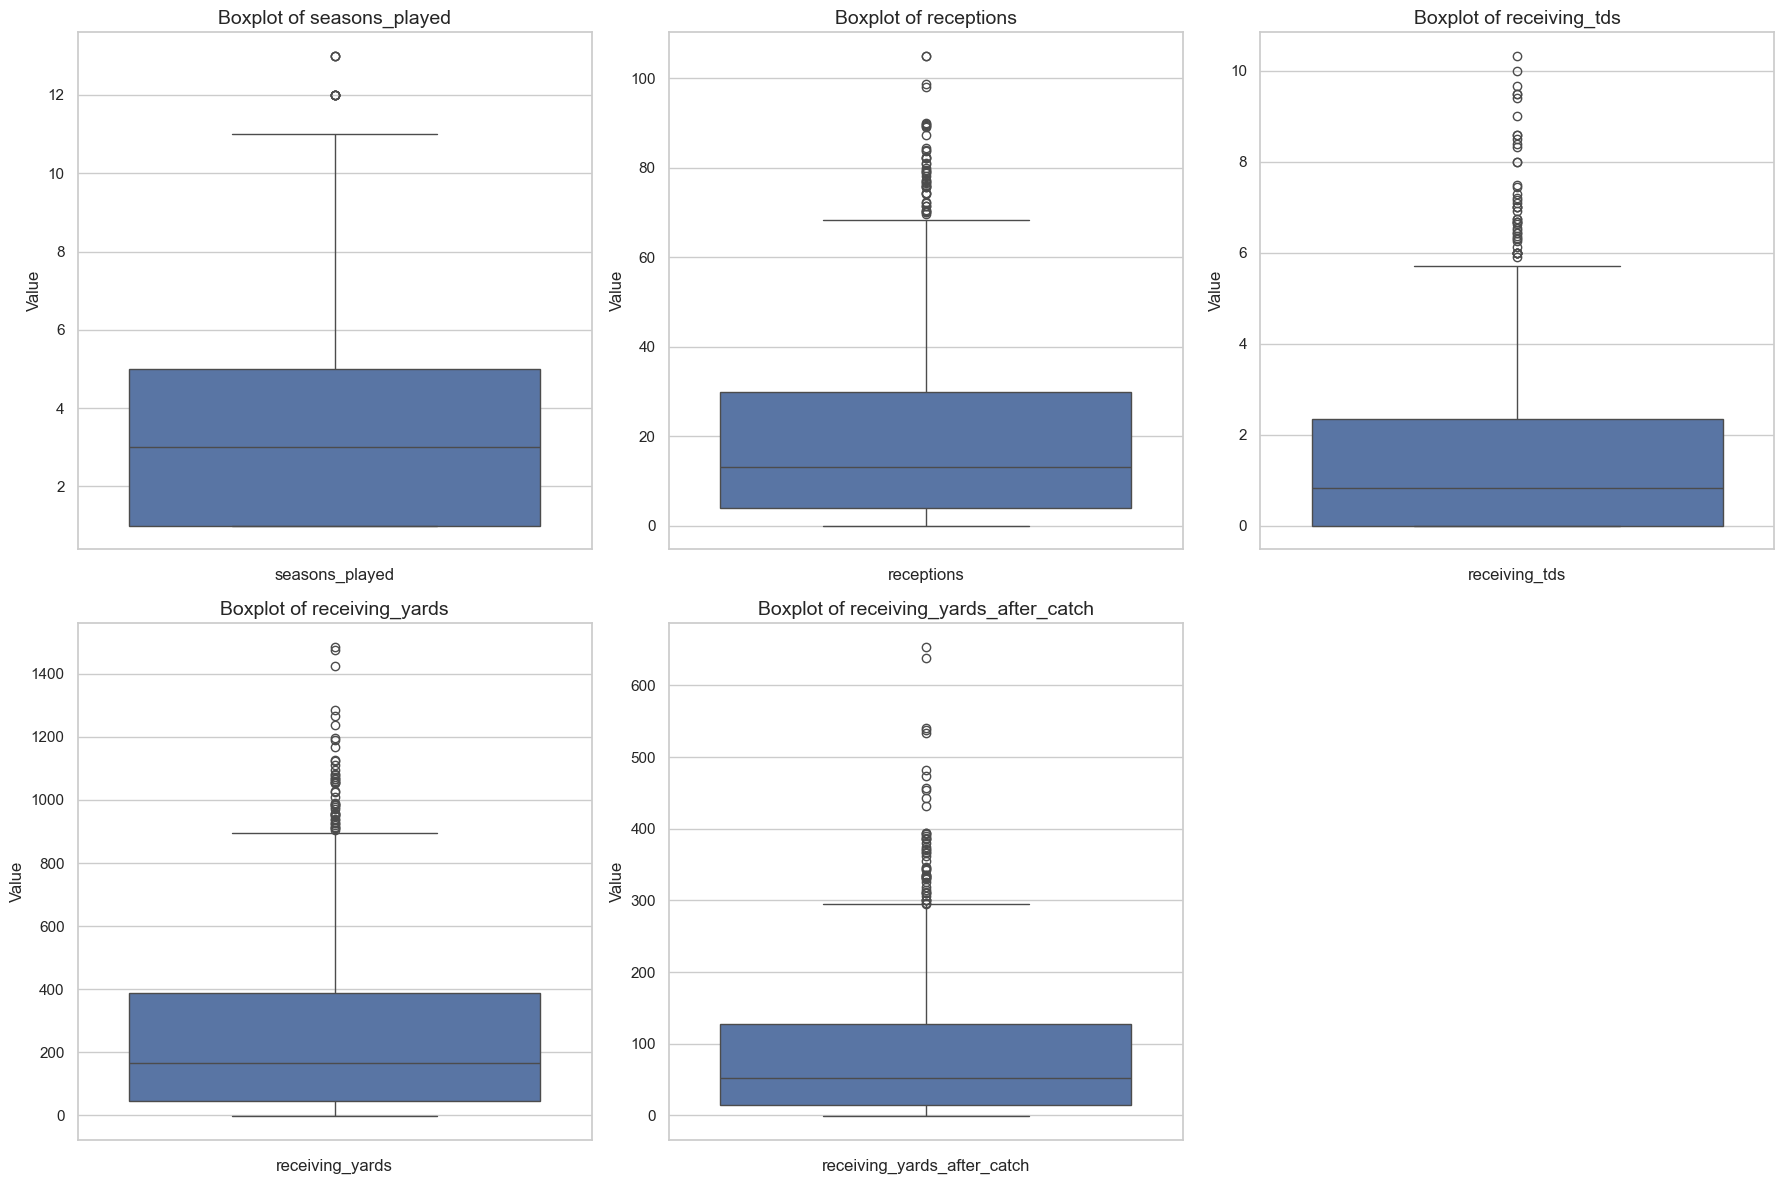

In [45]:
# Boxplot of the Season performance metrics per player

# Number of columns in the grid
n_cols = 3

# Calculate the number of rows needed
n_rows = (len(season_columns) // n_cols) + (len(season_columns) % n_cols > 0)

# Create a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 12))
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Loop through each column and create a boxplot
for idx, column in enumerate(season_columns):
    sns.boxplot(data=df_player_averages[column], ax=axes[idx])
    axes[idx].set_title(f'Boxplot of {column}', fontsize=14)
    axes[idx].set_xlabel(column, fontsize=12)
    axes[idx].set_ylabel('Value', fontsize=12)

# Remove any empty subplots
for ax in axes[len(season_columns):]:
    ax.remove()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

The distribution of the data can be clearly seen in these box plots. Most of the players are in the lower part of the graph, which means that their performance is rather low compared to the top performers. You can see that the median number of seasons played is only 3. However, there are also players who can play over 10 seasons, which is of course very valuable from a football club perspective. This picture can also be seen in the other values. The top performers are the ones you want to find and keep, as these performances are well above average.

### Top Performances

As shown in the last chapter, you can clearly see that the best games clearly stand out from the others with their performance. That's why it's important to find out which players they are.

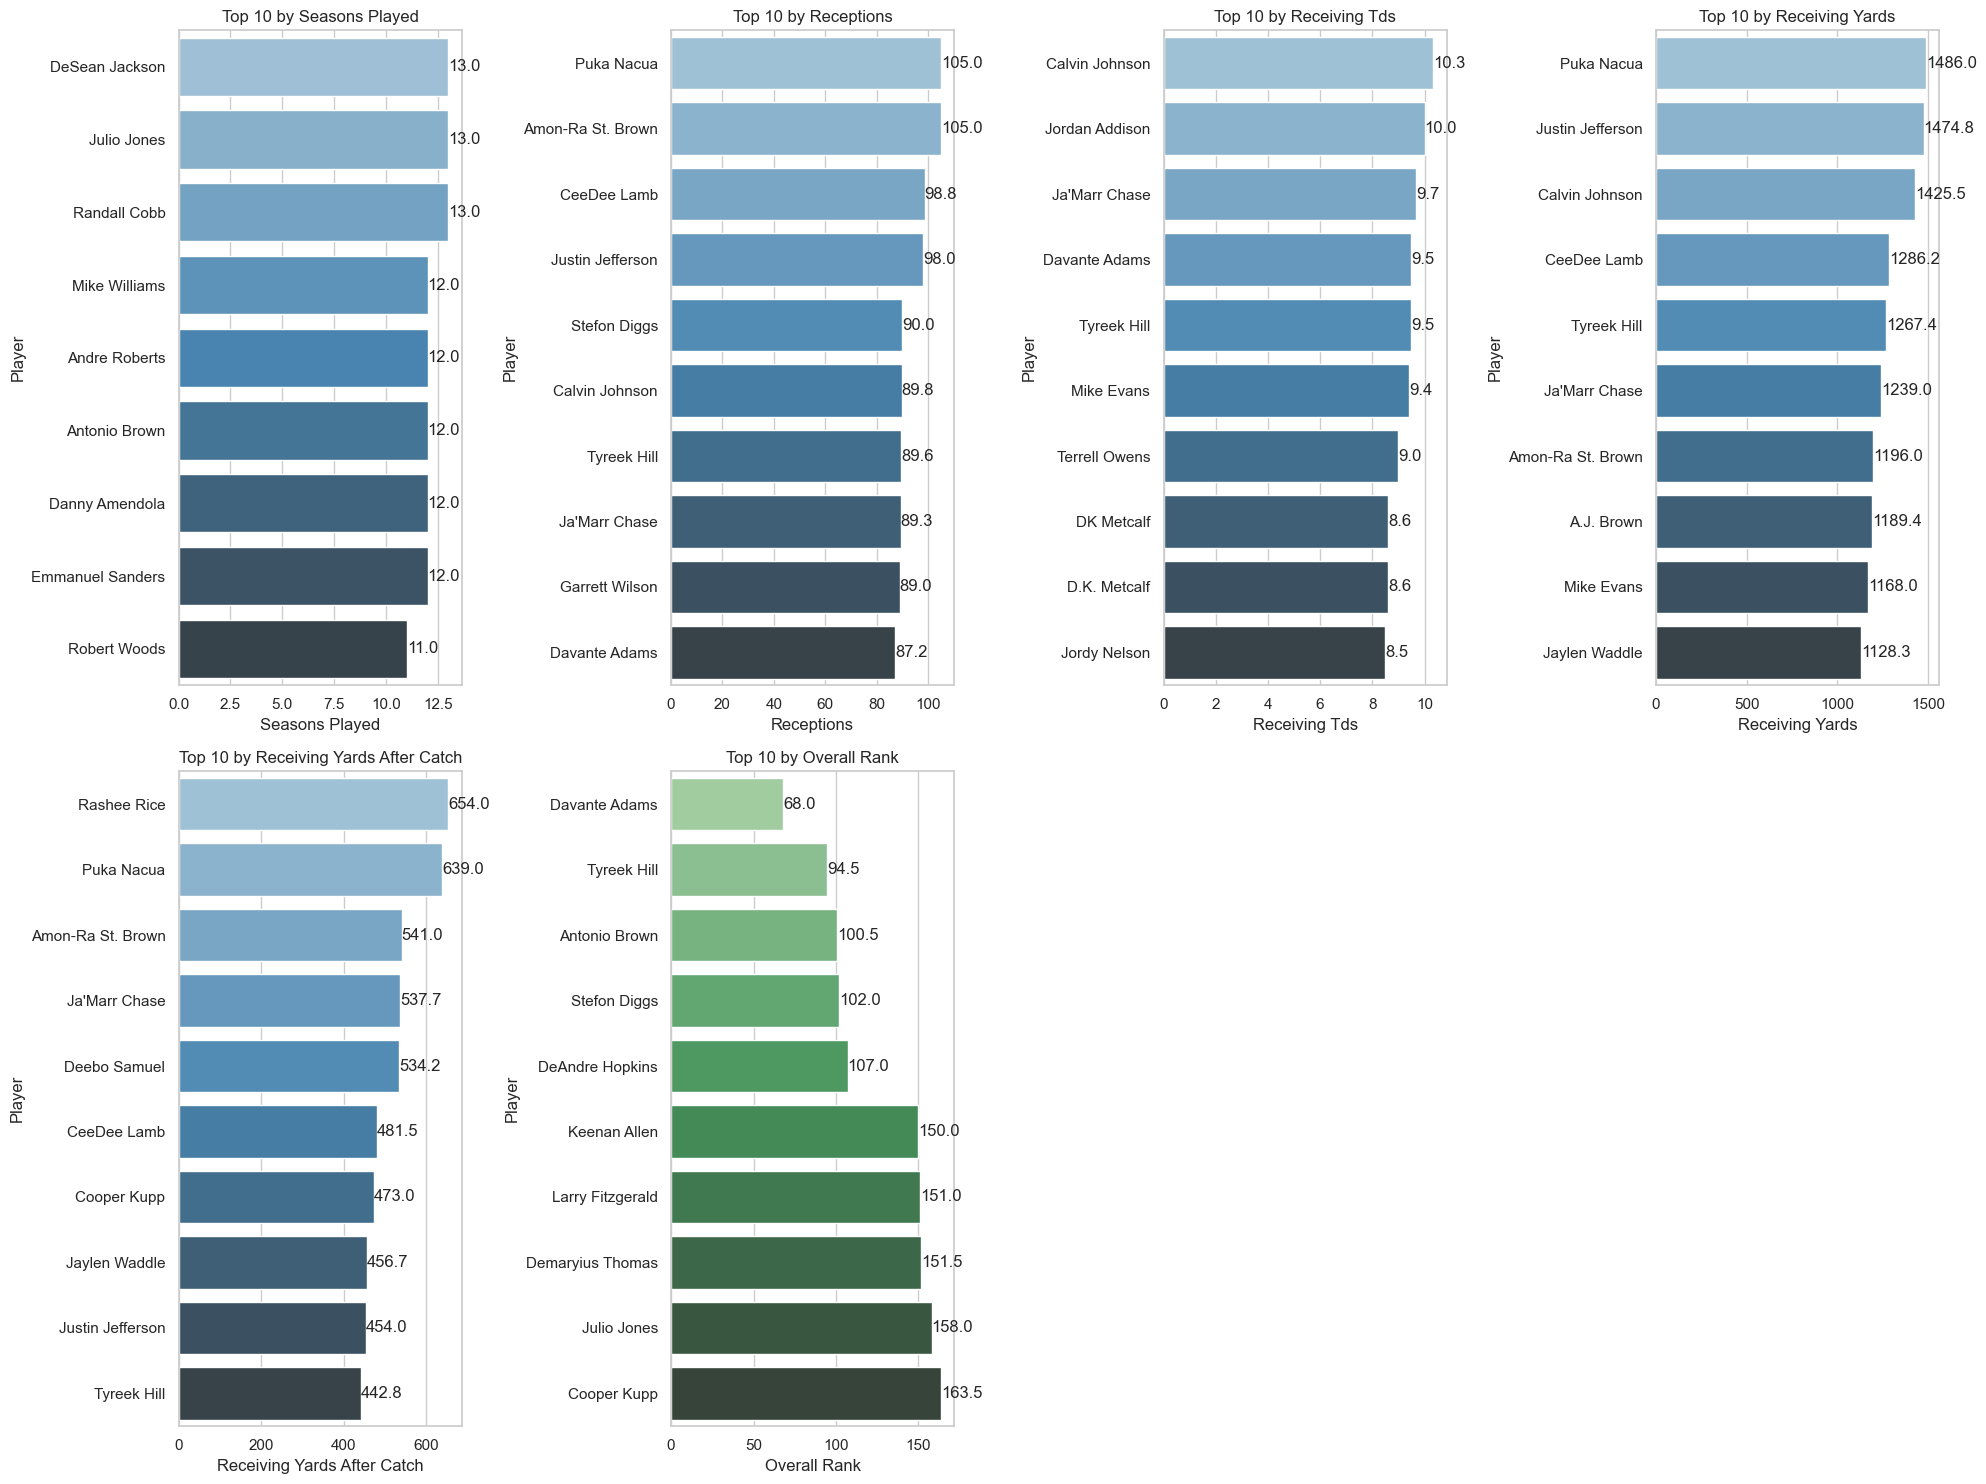

In [46]:
# Find the Top performer and display them
# Rank each column
for column in season_columns:
    df_player_averages[f'{column}_rank'] = df_player_averages[column].rank(ascending=False)

# Calculate overall rank by summing the ranks
df_player_averages['overall_rank'] = df_player_averages[[f'{column}_rank' for column in season_columns]].sum(axis=1)

# Set up the grid layout for subplots
n_cols = 4  # Number of columns in the grid
n_plots = len(season_columns) + 1  # Total number of plots (individual columns + overall rank)
n_rows = (n_plots // n_cols) + (n_plots % n_cols > 0)  # Calculate the number of rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))
axes = axes.flatten()  # Flatten to make indexing easier

# Loop over each column, rank it, and display the top 10
for idx, column in enumerate(season_columns):
    top_10_column = df_player_averages[['player_name', column, f'{column}_rank']].sort_values(by=f'{column}_rank').head(10)
    
    # Plotting the top 10 players for each column
    bar_plot = sns.barplot(x=column, y='player_name', hue='player_name', data=top_10_column, 
                           ax=axes[idx], palette="Blues_d", dodge=False, legend=False)
    
    # Display the values on the bars
    for container in bar_plot.containers:
        bar_plot.bar_label(container, fmt='%.1f', label_type='edge')
    
    # Customize the subplot
    axes[idx].set_title(f"Top 10 by {column.replace('_', ' ').title()}")
    axes[idx].set_xlabel(column.replace('_', ' ').title())
    axes[idx].set_ylabel('Player')

# Plot the overall rank in the next available subplot
top_10_overall = df_player_averages[['player_name'] + season_columns + ['overall_rank']].sort_values(by='overall_rank').head(10)

bar_plot_overall = sns.barplot(x='overall_rank', y='player_name', hue='player_name', data=top_10_overall, 
                               ax=axes[len(season_columns)], palette="Greens_d", dodge=False, legend=False)

# Display the values on the bars for the overall rank plot
for container in bar_plot_overall.containers:
    bar_plot_overall.bar_label(container, fmt='%.1f', label_type='edge')

# Customize the overall rank subplot
axes[len(season_columns)].set_title(f"Top 10 by Overall Rank")
axes[len(season_columns)].set_xlabel('Overall Rank')
axes[len(season_columns)].set_ylabel('Player')

# Remove any extra empty subplots
for ax in axes[len(season_columns) + 1:]:
    ax.remove()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the grid of plots
plt.show()


The best players are shown here in the respective metrics. To make the overall evaluation, a score was calculated from the respective rankings in the individual values to find out which players performed best overall. In the performance data you can see that the rather young players are very high up, like a Puca Nacua (one season played). It is certainly easier to perform well in one season than over a longer period of time. That's why the number of seasons played was also included in the ranking.

## Influence of combine Data on seasonal Performance

This chapter aims to clarify the correlation between the combine data and the saisonal statistics

### Correlation of combine data and seasonal data

In order to better anticipate the influence of the individual metrics, we compare all data from the combine with all data from the season. This makes it possible to show which Combine dates have an influence on which seasonal data.

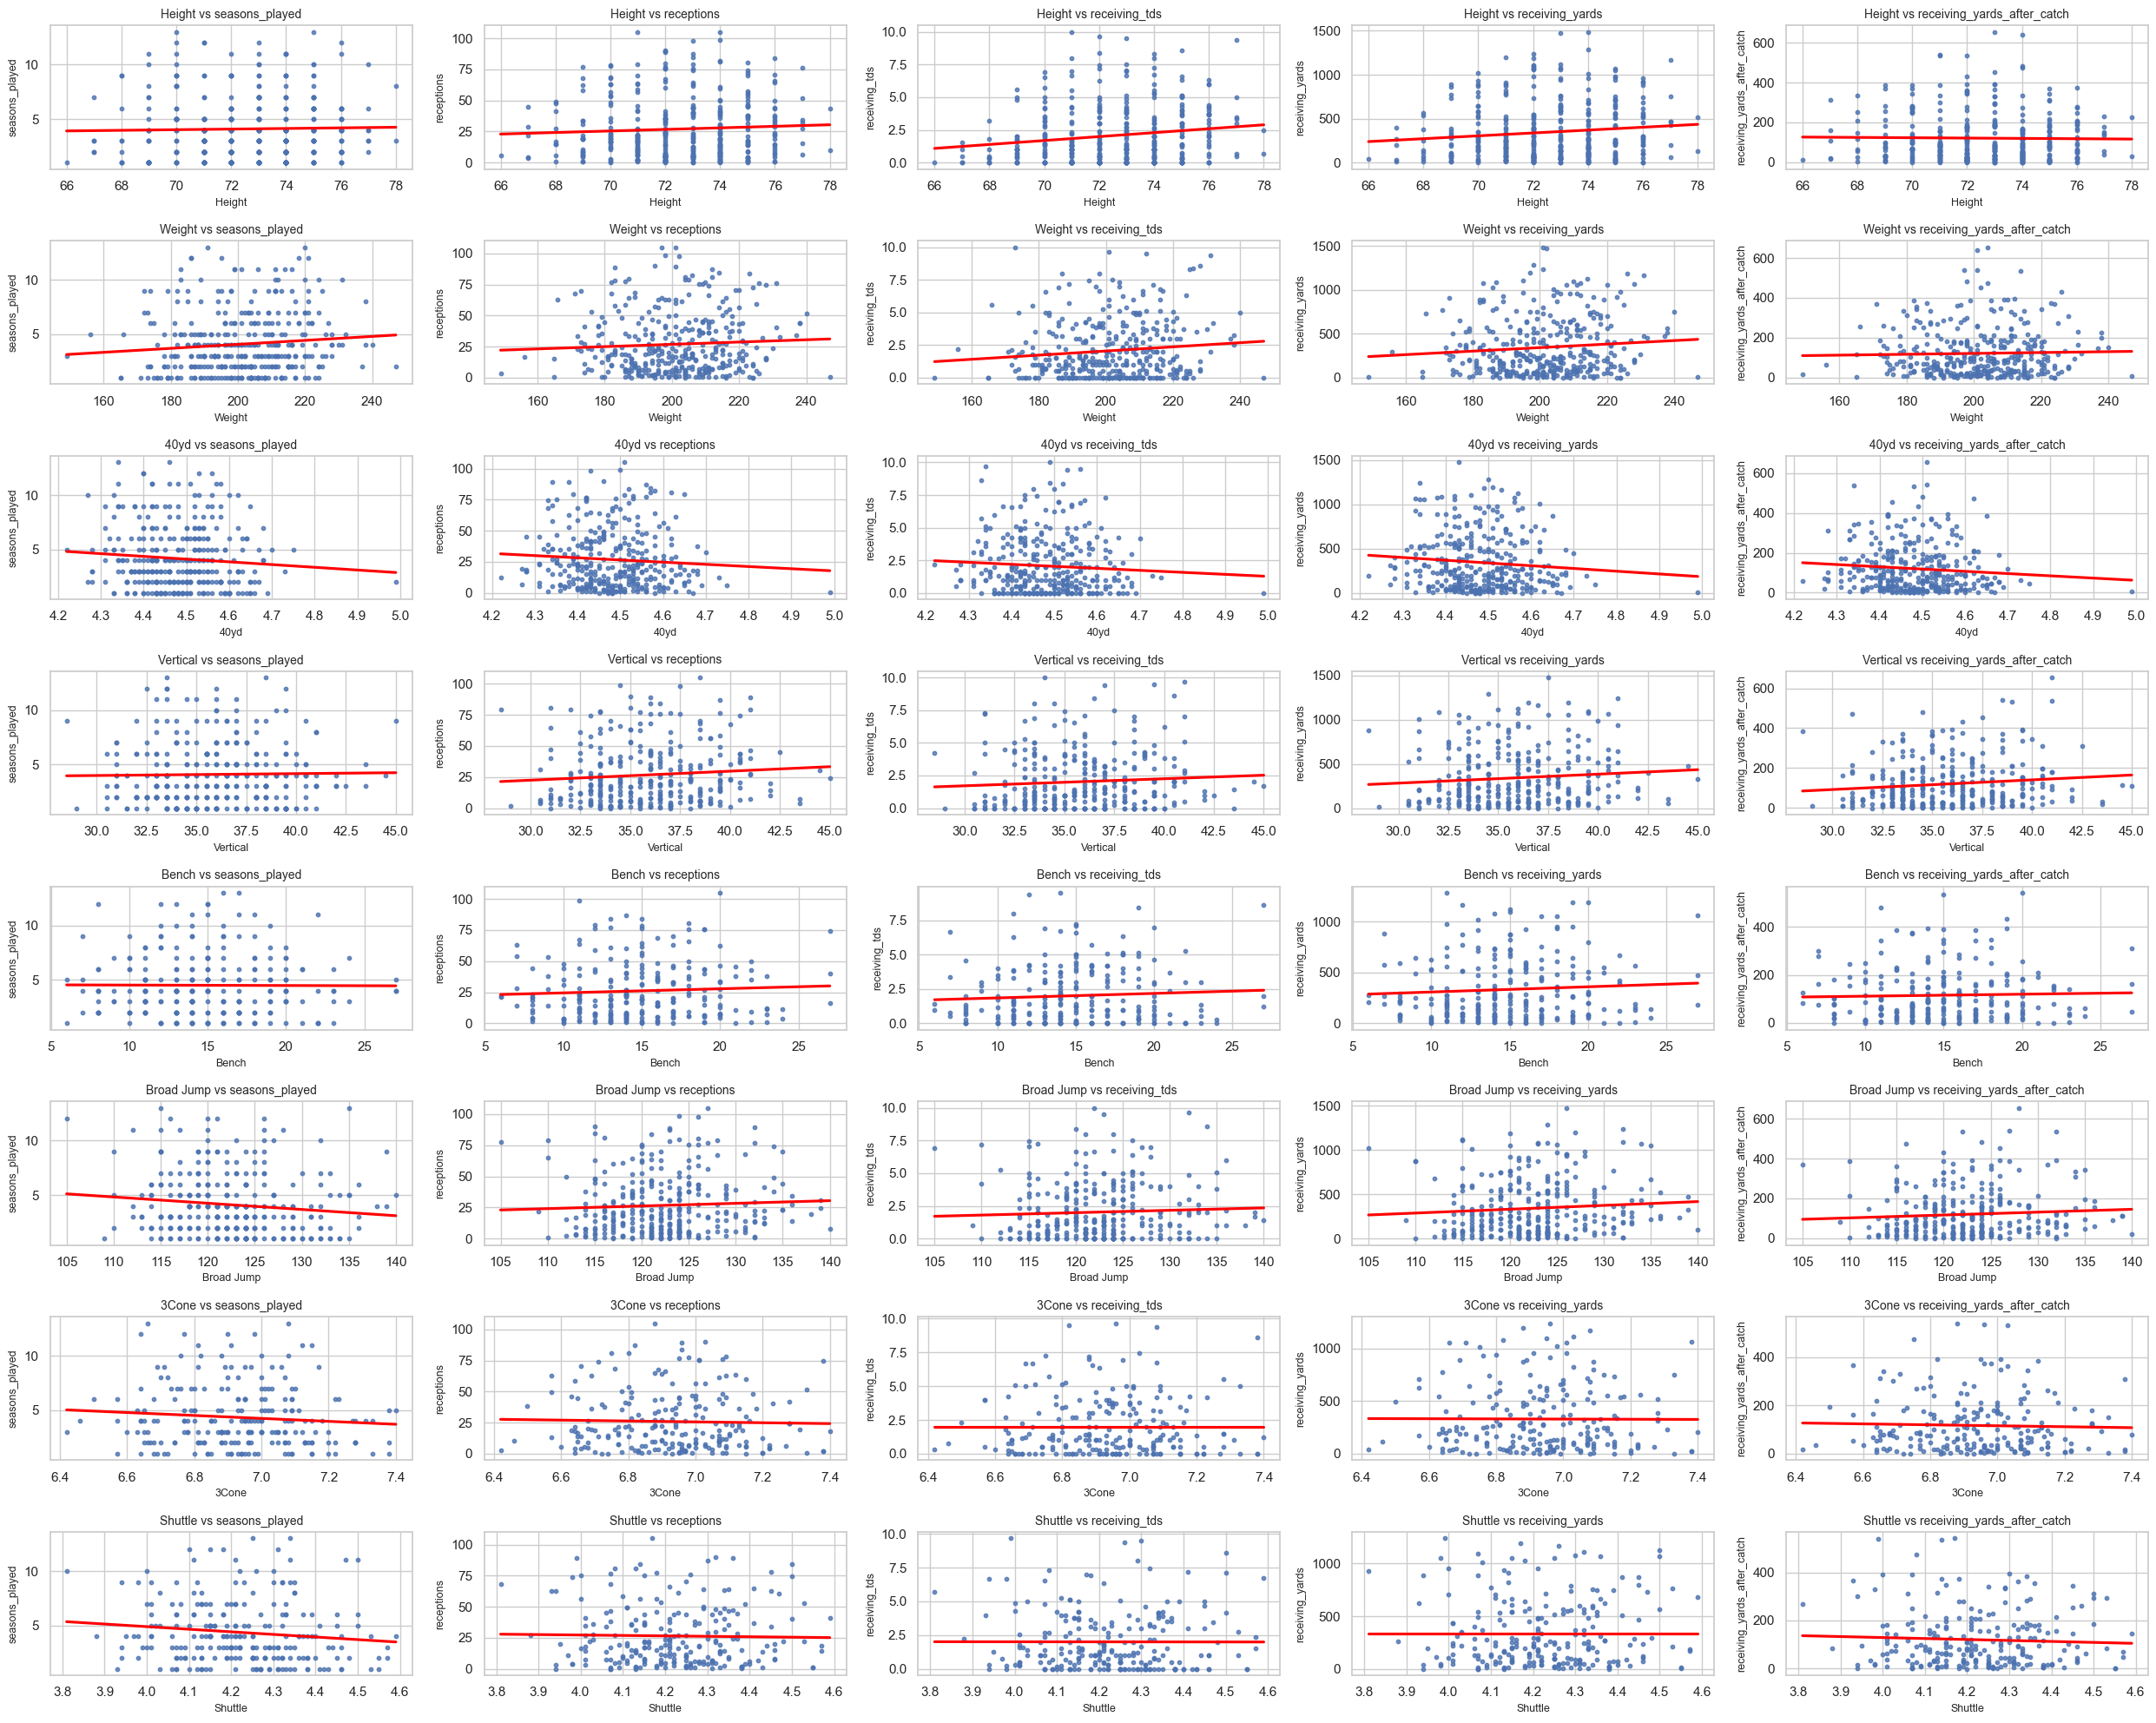

In [47]:
# Showing the correlation of the combine metrics on the seasonal data

# Set up the grid dimensions based on the number of combinations (rows and cols)
rows = len(combine_columns)
cols = len(season_columns)

# Create subplots grid
fig, axes = plt.subplots(rows, cols, figsize=(25, 20))
fig.tight_layout(pad=4.0)  # Adjust padding between subplots

# Loop through each combination of columns
for i, combine_column in enumerate(combine_columns):
    for j, season_column in enumerate(season_columns):
        # Create scatterplot with linear model
        sns.regplot(x=combine_column, y=season_column, data=df_player_averages, 
                    ax=axes[i, j], scatter_kws={'s': 10}, line_kws={'color': 'red'}, ci=None)
        
        # Customize each subplot title
        axes[i, j].set_title(f'{combine_column} vs {season_column}', fontsize=10)
        axes[i, j].set_xlabel(combine_column, fontsize=9)
        axes[i, j].set_ylabel(season_column, fontsize=9)

# Adjust layout and show the grid of plots
plt.tight_layout()
plt.show()


You can see a certain correlation in most comparisons, but that does not mean that there is a real connection. The influence of 40yd time on performance in the NFL is most clearly visible. A faster time has a positive effect on performance in all metrics.

### Top Performances

Since a direct correlation from the Combine data is difficult to determine, the performance of the best NFL players from the overall ranking is looked at here. How did they perform in the combine and can anything be deduced from this?

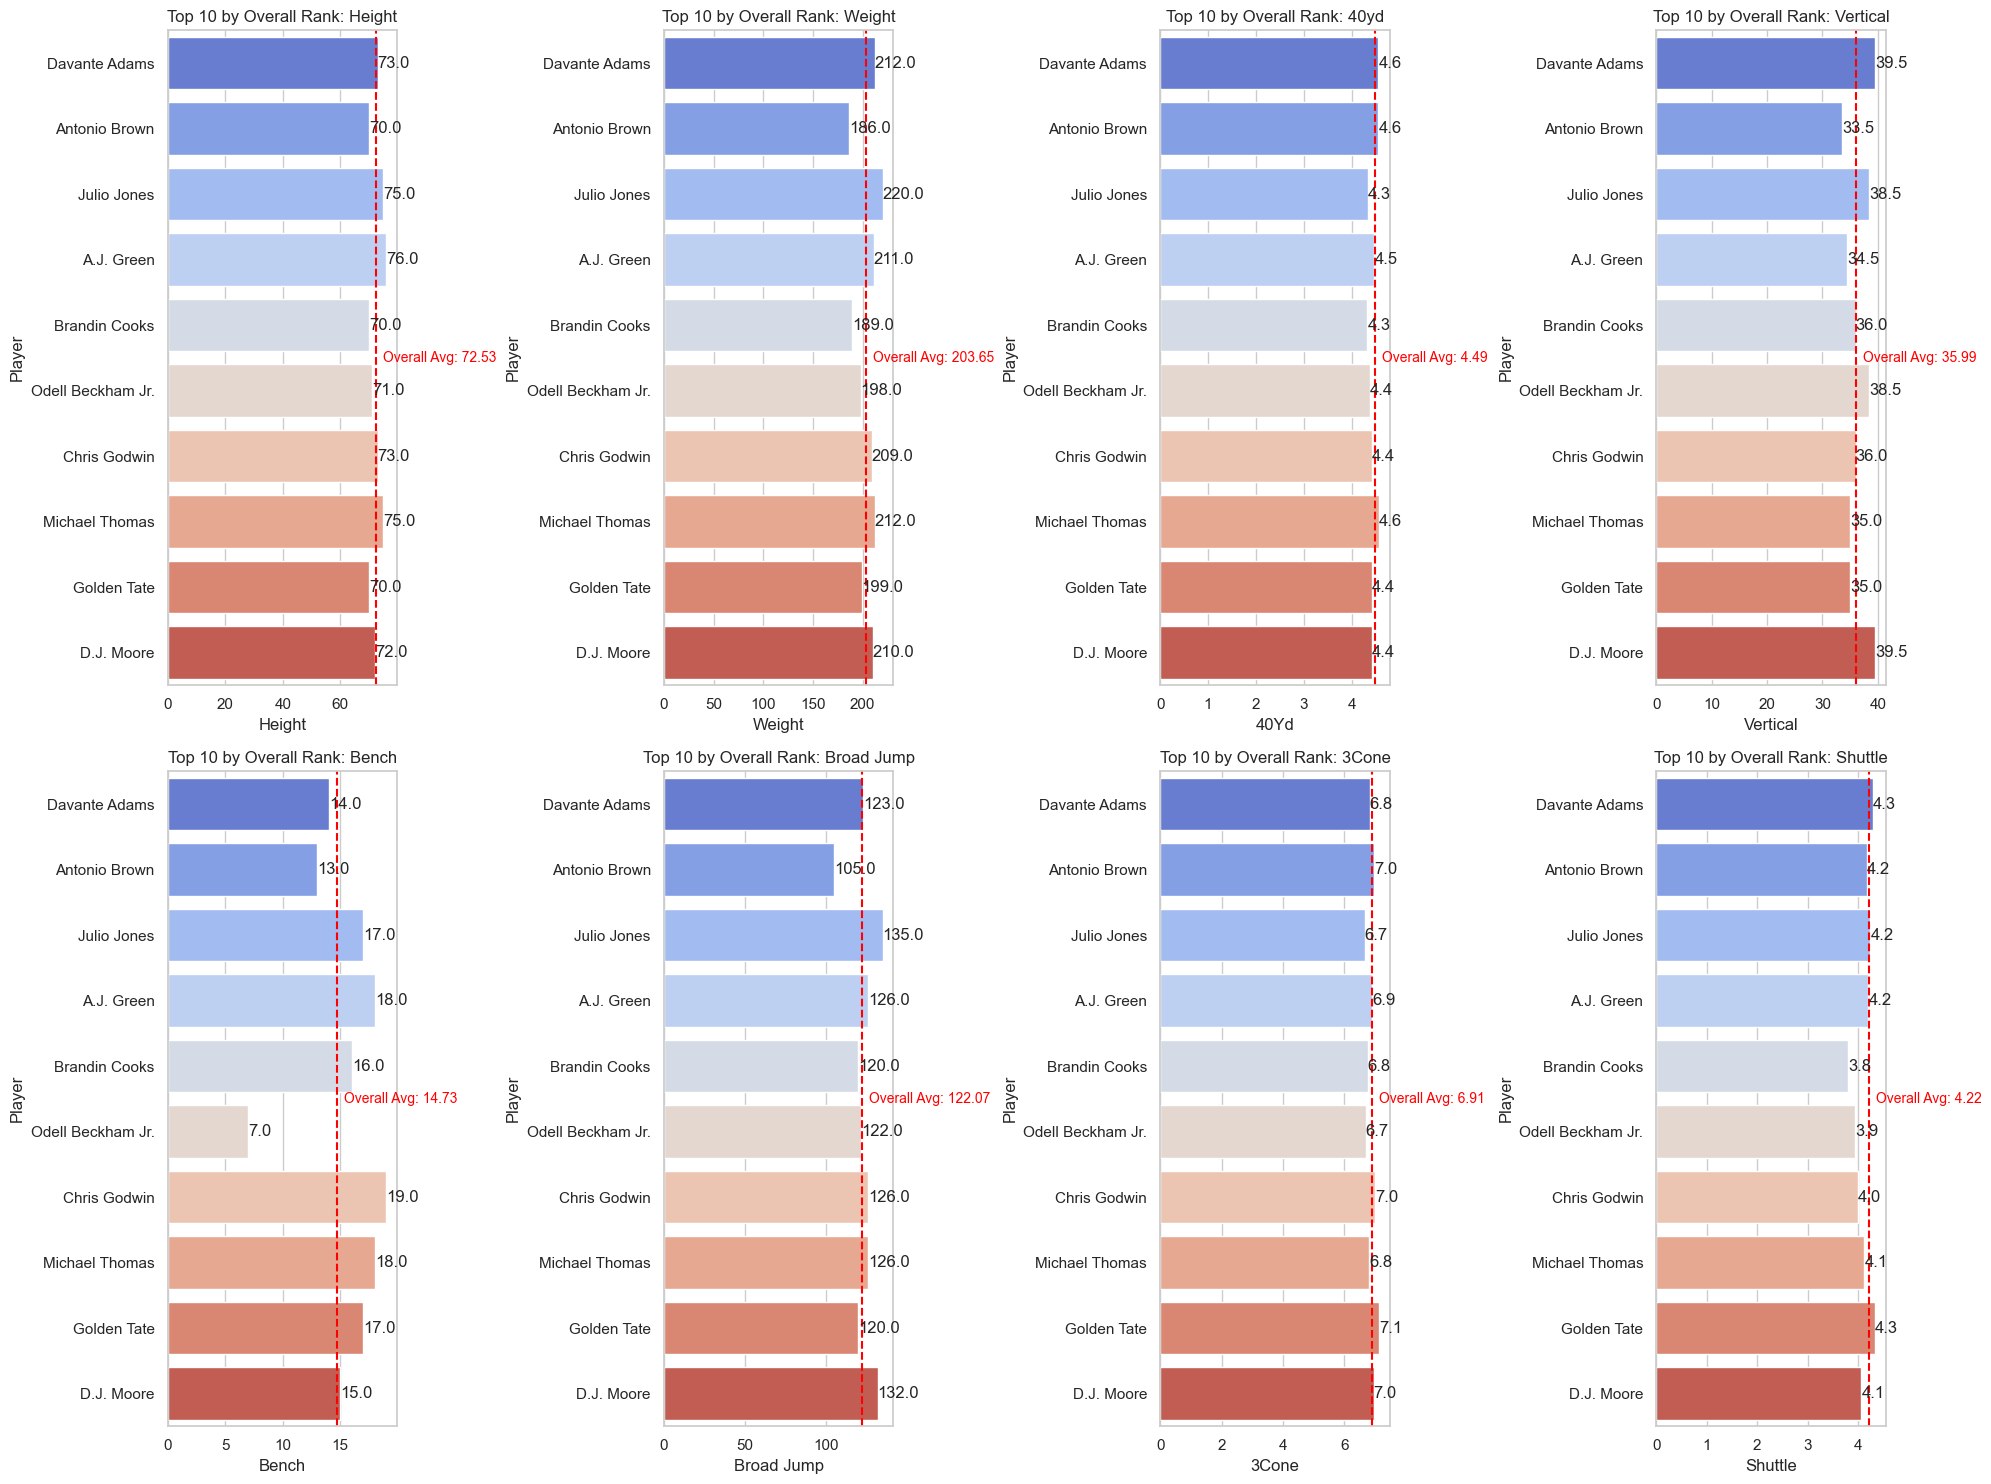

In [48]:
# Compare the top ranked players based on their Combine result
# Filter players who have no missing values (NAs) in the combine columns
df_cleaned = df_player_averages.dropna(subset=combine_columns)

# Get the top 10 players by overall rank who have complete combine data
top_10_overall = df_cleaned.sort_values(by='overall_rank').head(10)

# Set up the grid layout for subplots
n_cols = 4  # Number of columns in the grid
n_plots = len(combine_columns)  # Total number of plots (for each combine column)
n_rows = (n_plots // n_cols) + (n_plots % n_cols > 0)  # Calculate the number of rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))
axes = axes.flatten()  # Flatten to make indexing easier

# Loop over each combine column and display the top 10 players' stats with overall average
for idx, column in enumerate(combine_columns):
    # Calculate the overall average for the current column
    overall_average = df_cleaned[column].mean()
    
    # Plot the data for the top 10 players in the current physical attribute
    bar_plot = sns.barplot(x=column, y='player_name', hue='player_name', data=top_10_overall, 
                           ax=axes[idx], palette="coolwarm", dodge=False, legend=False)
    
    # Display the values on the bars
    for container in bar_plot.containers:
        bar_plot.bar_label(container, fmt='%.1f', label_type='edge')
    
    # Add a vertical line to indicate the overall average
    axes[idx].axvline(overall_average, color='red', linestyle='--', label='Overall Avg')
    
    # Customize the subplot
    axes[idx].set_title(f"Top 10 by Overall Rank: {column}")
    axes[idx].set_xlabel(column.replace('_', ' ').title())
    axes[idx].set_ylabel('Player')

    # Annotate the overall average on the plot
    axes[idx].annotate(f'Overall Avg: {overall_average:.2f}', xy=(overall_average, 0.5), 
                       xycoords=('data', 'axes fraction'), textcoords='offset points', 
                       xytext=(5, 0), ha='left', va='center', fontsize=10, color='red')

# Remove any extra empty subplots
for ax in axes[len(combine_columns):]:
    ax.remove()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the grid of plots
plt.show()


Only players who also performed in the Combine could be evaluated here, which is why this top 10 differs from those in the previous chapter. For the 10 players, their respective performance per discipline is shown as well as the average of all performances in the Combine. From this analysis you can see that the performances of these players in the combine are quite close to the average value and that they are not the players who are outstanding in certain disciplines. Of course, there are also outliers, especially in bench pressing, but this value is also of secondary importance for wide receivers.

### Model to predict Performance

In order to understand the influence of Combine performance on NFL performance from a different perspective and to draw conclusions from it, we have tried to calculate the influence with the help of a model.

Mean Squared Error: 21624.711997457573
R-squared: -0.3088025100329215
      Feature  Importance
4  Broad Jump    0.235971
2        40yd    0.211028
1      Weight    0.208549
3    Vertical    0.189332
0      Height    0.155120


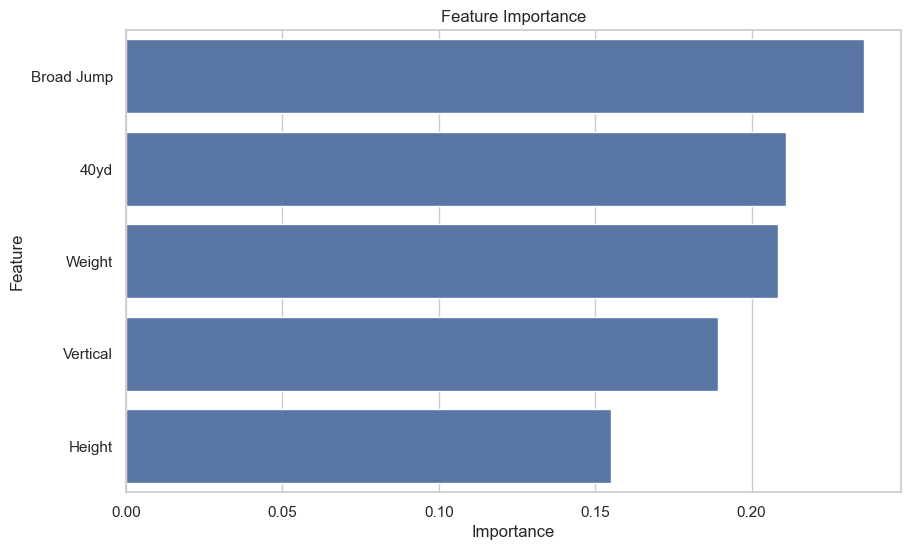

In [49]:
# Model Influnce of Combine Performance

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Filter rows that have no missing values in the X columns
X = df_player_averages[['Height', 'Weight', '40yd', 'Vertical', 'Broad Jump']]

# Drop rows with any NaN values in these columns
X_clean = X.dropna()

# Filter y based on the indices of X_clean
# Assuming y is the target variable receiving_yards (adjust this for your case)
y_clean = df_player_averages.loc[X_clean.index, 'receiving_yards_after_catch']

# 4. Train-Test Split (use the cleaned X and y)
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

# 5. Initialize the model (you can also use other models like LinearRegression, GradientBoosting, etc.)
model = RandomForestRegressor(n_estimators=100, random_state=42)

# 6. Train the model
model.fit(X_train, y_train)

# 7. Predict on the test set
y_pred = model.predict(X_test)

# 8. Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# 9. Feature Importance (to understand which combine metrics influence performance the most)
importances = model.feature_importances_
feature_names = X_clean.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

# Optional: Plot the feature importances
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()


Only certain values were taken here, as not all of them have a direct influence and therefore a selection was made. The influence is calculated for the Metric Receiving Yards after Catch, as this value reflects the performance of the receiver the most. The model shows that the Broad jump has the greatest influence in this model, followed by the 40yd. However, this result must be put into perspective. The model does not represent reality very well, as can be seen from the negative R squared value. Unfortunately, this model is therefore not suitable for calculating the performance of a player from the Combine data.

# Insight and data usage via a dashboard

If a recognizable dependency between Combine values and seasonal performance emerges in the future, data like that used in this report could be used to make data-based decisions in the draft process. One way of optimizing this for the target group of team analysts would be to use it in a BI-tool (Business Intelligence). This would allow the data to be used in an appealing and profitable way through visualizations and specific filter functions. You can find out what such a solution could look like in the appending file "main_nfl_app.py".

We highly recommend to open the file and test out the different options to get a deeper insight into the world of NFL data.

# Final thoughts

The NFL offers a lot of data and there are so many statistics and metrics that are collected and that's what makes this sport so interesting. Therefore, the assumption is that this data can be better utilized to make better decisions. Of course, the variety of data also makes it more difficult to find the right and relevant data for the evaluations and to incorporate it into an analysis accordingly. Just because a lot of data is available does not mean that it can be analyzed. We were able to highlight the diversity of the data in our analysis, and even within this small selection of data, there were various directions one could take. We decided to compare the performances of wide receivers from the Combine with their season data and possibly anticipate future performances from that. Unfortunately, a direct influence of the Combine data could not be identified in this evaluation. It was very clear, however, that the best players stood out significantly from the average. Therefore, it would be crucial to identify these players in the Combine and draft them. However, the given data did not clearly show that these players would deliver such strong performances later in the NFL. Also a machine model was used to answer our research question, but there was also no direct evidence discoverable and so the model cannot be used to determine the performance of the NFL players. In conclusion there is some evidence, that the performance in the combine has an influence, but we couldnt determine in what capacity. For a further investigation more data would be useful, maybe that would help to have better results.